## Setup

In [ ]:
!pip install PyPortfolioOpt
# import numpy and pandas
import numpy as np
import pandas as pd

# import datetime
import datetime
from datetime import datetime, date

# import deepcopy
from copy import deepcopy

# import matplotlib
import matplotlib.pyplot as plt

# import yfinance
import yfinance as yf

# import norm
from scipy.stats import norm, binom, t
from math import sqrt

import pypfopt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

%matplotlib inline

In [ ]:
#Download 3 Stocks from Yahoo Finance
start_date = '2018-01-01'  # Start date of the period
end_date = '2023-12-31'

# Download for Apple
aapl_data = yf.download("AAPL", start=start_date, end=end_date)

# Download for Boeing
ba_data = yf.download("BA", start=start_date, end=end_date)

# Download for Cisico
csco_data = yf.download("CSCO", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Historical VaR and ES


In [ ]:
# Log return for Apple
aapl_data['Prev Close'] = aapl_data['Adj Close'].shift(1)
aapl_data['Daily Return'] = (aapl_data['Adj Close'] - aapl_data['Prev Close']) / aapl_data['Prev Close']
aapl_data['Log Return'] = np.log((aapl_data['Adj Close']/aapl_data['Prev Close']))

# Log return for Boeing
ba_data['Prev Close'] = ba_data['Adj Close'].shift(1)
ba_data['Daily Return'] = (ba_data['Adj Close'] - ba_data['Prev Close']) / ba_data['Prev Close']
ba_data['Log Return'] = np.log((ba_data['Adj Close']/ba_data['Prev Close']))

# Log return for Cisco
csco_data['Prev Close'] = csco_data['Adj Close'].shift(1)
csco_data['Daily Return'] = (csco_data['Adj Close'] - csco_data['Prev Close']) / csco_data['Prev Close']
csco_data['Log Return'] = np.log((csco_data['Adj Close']/csco_data['Prev Close']))

In [ ]:
# Shares
shares = {"Apple": 200, "Boeing": 300, "Cisco": 1000}

# Making the portfolio based on weights
portfolio_df = aapl_data * shares['Apple'] + ba_data * shares['Boeing'] + csco_data * shares["Cisco"]
portfolio_df['Prev Close'] = portfolio_df['Adj Close'].shift(1)
portfolio_df['Daily Return'] = ((portfolio_df['Adj Close']) / portfolio_df['Prev Close']) - 1
portfolio_df['Log Return'] = np.log((portfolio_df['Adj Close']/portfolio_df['Prev Close']))

In [ ]:
window = 250  # Rolling window size
alpha = 0.01 # Confidence level

# Calculate rolling VaR for whole period
portfolio_df['VaR_99_Hist'] = portfolio_df['Log Return'].rolling(window=window).quantile(alpha)

# Calculate VaR ES for whole period
portfolio_df['ES_99_Hist'] = portfolio_df['Log Return'].rolling(window=window).apply(lambda x: x[x < x.quantile(alpha)].mean())

# Filter to specified date
selected_period = portfolio_df.loc['2018-12-31':'2023-12-28'].copy()

# Convert rolling VaR and ES back to arthimetic
selected_period['VaR_99_Hist'] = np.exp(selected_period['VaR_99_Hist']) - 1
selected_period['ES_99_Hist'] = np.exp(selected_period['ES_99_Hist']) - 1

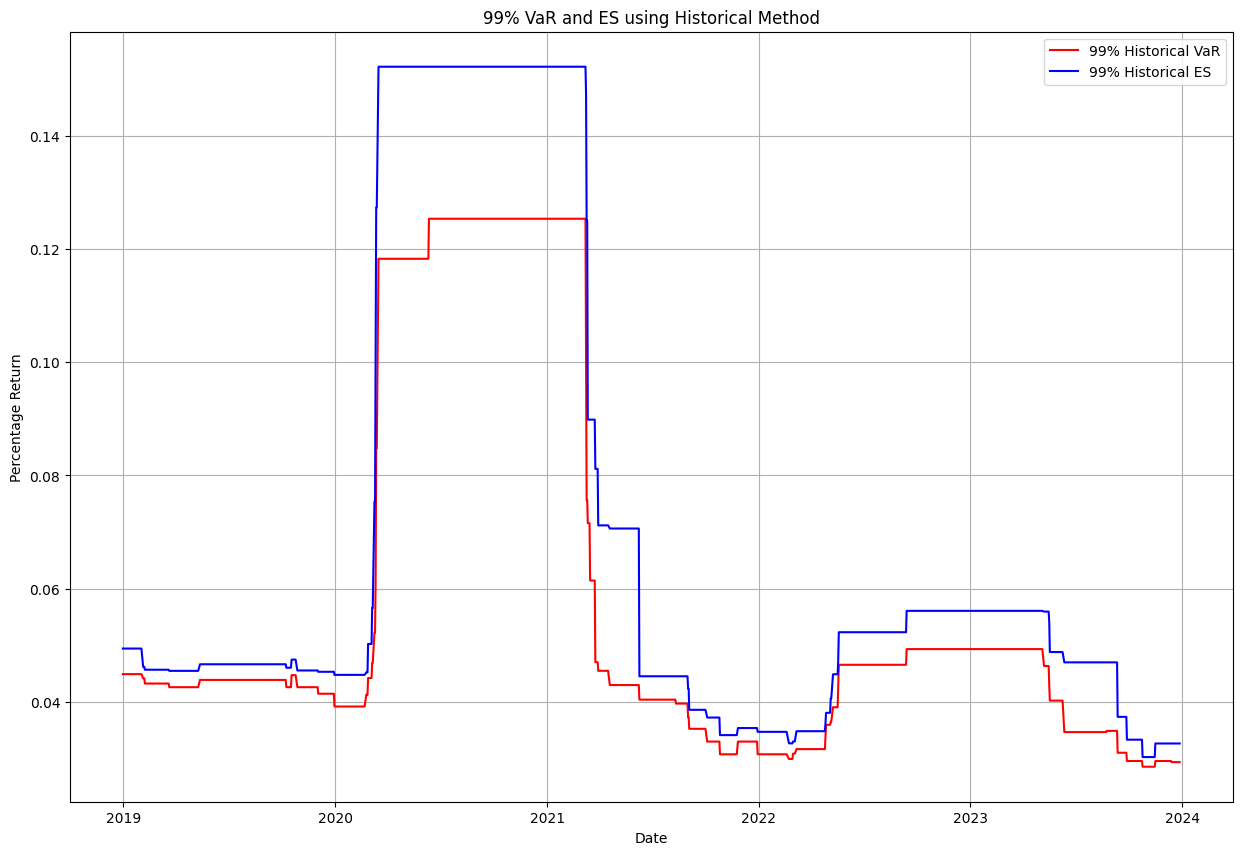

In [ ]:
# Plot VaR and ES
plt.figure(figsize=(15, 10))
plt.plot(selected_period.index, -selected_period['VaR_99_Hist'], label=f'99% Historical VaR', color='red')
plt.plot(selected_period.index, -selected_period['ES_99_Hist'], label=f'99% Historical ES', color='blue')
plt.xlabel('Date')
plt.ylabel('Percentage Return')
plt.title('99% VaR and ES using Historical Method')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Last day
last_VaR = selected_period.iloc[-1].VaR_99_Hist
last_ES = selected_period.iloc[-1].ES_99_Hist
last_day = selected_period.iloc[-1].name.strftime('%Y-%m-%d')

print('Historical Last Day Values: ')
print(f'Last Day: {last_day}')
print(f'VaR: {last_VaR}')
print(f'ES: {last_ES}')

Historical Last Day Values: 
Last Day: 2023-12-28
VaR: -0.02930831905232223
ES: -0.03260496326514317


## Parametric VaR and ES

In [ ]:
portfolio_df['aapl_adj_close'] = aapl_data['Adj Close']
portfolio_df['ba_adj_close'] = ba_data['Adj Close']
portfolio_df['csco_adj_close'] = csco_data['Adj Close']
portfolio_df['aapl_log_return'] = aapl_data['Log Return']
portfolio_df['ba_log_return'] = ba_data['Log Return']
portfolio_df['csco_log_return'] = csco_data['Log Return']

In [ ]:
def get_mean(df1, weights):

    aapl_mean = np.exp(df1['aapl_log_return'].mean()) -1
    ba_mean = np.exp(df1['ba_log_return'].mean()) -1
    csco_mean = np.exp(df1['csco_log_return'].mean()) -1

    means = [aapl_mean, ba_mean, csco_mean]

    return np.log(np.dot(means, weights.T)+1)

In [ ]:
def get_past_250_sd(df1, weights):

    val = df1[['aapl_log_return','ba_log_return','csco_log_return']].values
    # Calculating Covariance for the 3 stocks
    vcv = np.cov(val.T)
    # Calculating Variance of portfolio
    variance = np.dot(weights, np.dot(vcv, weights))
    return sqrt(variance)

In [ ]:
def get_weights (df1):

    aapl_price = df1.iloc[-1]['aapl_adj_close'] * 200
    ba_price = df1.iloc[-1]['ba_adj_close'] * 300
    csco_price = df1.iloc[-1]['csco_adj_close'] * 1000

    total_port = aapl_price + ba_price + csco_price

    return np.array([(aapl_price / total_port), (ba_price / total_port), (csco_price / total_port)])

In [ ]:
# Getting rolling VaR and ES with parametric method

# Deep copy dataframe 'seperate_returns'
pf = deepcopy(portfolio_df)
pf = pf.reset_index()
# Get z-score
z_score = norm.ppf(0.01, loc=0, scale=1)

copy = pf.copy()
copy.reset_index(inplace=True)

for i in range(0, len(pf)):
    past_250 = pf.loc[(i-249):(i)].copy()
    if len(past_250) == 250:
        weights = get_weights(past_250)
        mean = get_mean(past_250, weights)
        sd = get_past_250_sd(past_250, weights)
        pf.loc[i, 'VaR_99_Param'] =  np.exp(mean + sd * z_score) - 1
        pf.loc[i, 'ES_99_Param'] = np.exp((mean - sd * (norm.pdf(z_score)/(1-0.99)))) - 1
    else:
        pf.loc[i, 'VaR_99_Param'] = np.NaN
        pf.loc[i, 'ES_99_Param'] = np.NaN

start_date = '2018-12-31'
end_date = '2023-12-28'
selected_period_parametric = pf[(pf['Date'] >= start_date) & (pf['Date'] <= end_date)]

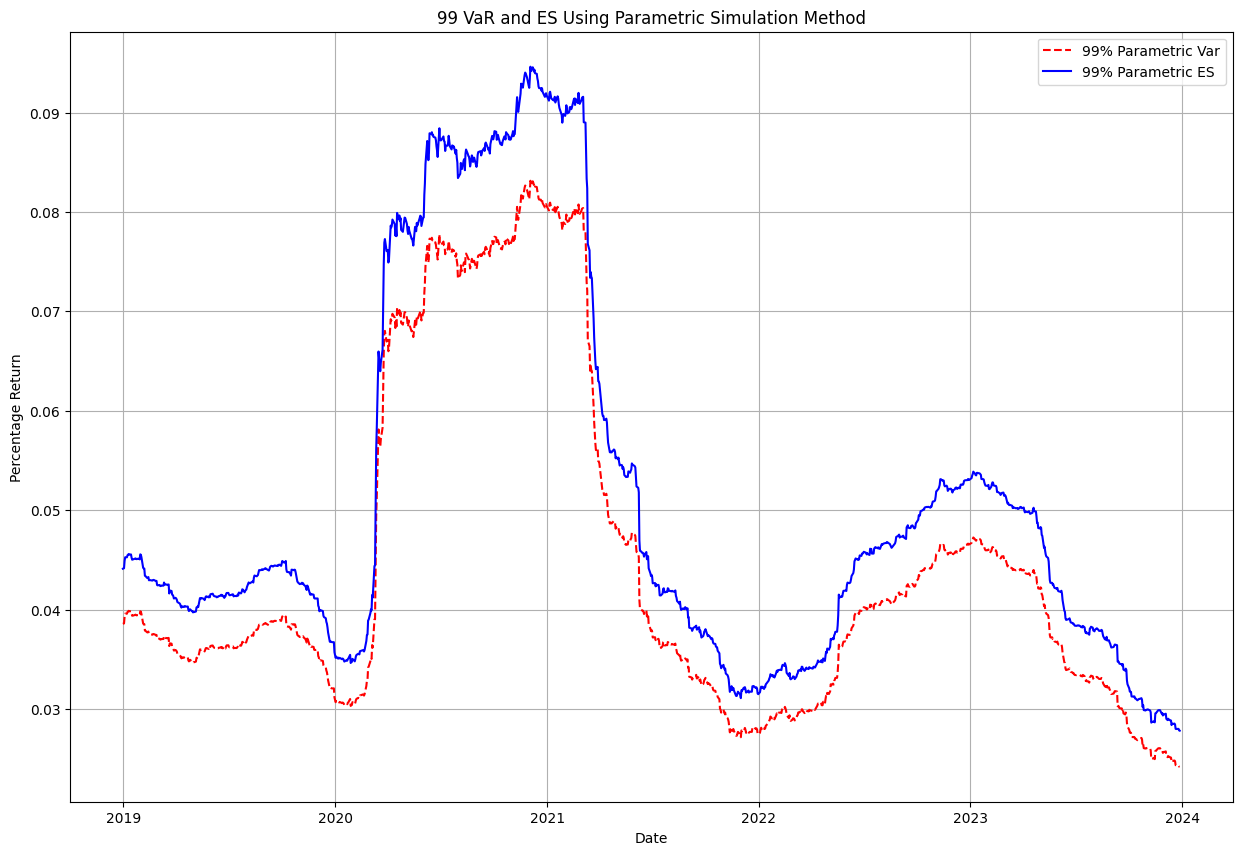

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(selected_period_parametric['Date'], -selected_period_parametric['VaR_99_Param'], 'r--', label='99% Parametric Var')
plt.plot(selected_period_parametric['Date'], -selected_period_parametric['ES_99_Param'], 'b-', label='99% Parametric ES')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Percentage Return')
plt.legend()
plt.title('99 VaR and ES Using Parametric Simulation Method')
plt.show()

In [ ]:
# Last day
last_VaR = selected_period_parametric.iloc[-1].VaR_99_Param
last_ES = selected_period_parametric.iloc[-1].ES_99_Param
last_day = selected_period.iloc[-1].name.strftime('%Y-%m-%d')

print('Parametric Last Day Values: ')
print(f'Last Day: {last_day}')
print(f'VaR: {-last_VaR}')
print(f'ES: {-last_ES}')

Parametric Last Day Values: 
Last Day: 2023-12-28
VaR: 0.02418356443863856
ES: 0.02781105858020516


Both plots exhibit similar trends in VaR and ES over the time period analyzed. There is a noticeable surge in both VaR and ES (in terms of magnitude) from 2020 to mid-2021.

In this period, for the Parametric method, the VaR increased from about 3.5% to 8.5% and the ES increased from about 4.0% to 9.5%. As it was calculated at the 99% level, this means that in this period, the portfolio is expected to lose more than 8.5% of the portfolio 1% of the time. It also means that everytime he crosses the 8.5% VaR threshold, he is expected to lose around 9.5%.

For the Historic method, the VaR increased from about 4.0% to 12.5% and the ES increased from about 5.0% to 15.0%. As it was calculated at the 99% level, this means that in this period, the portfolio is expected to lose more than 12.5% of the portfolio 1% of the time. It also means that everytime he crosses the 8.5% VaR threshold, he is expected to lose around 15.0%.

This trend is likely attributable to the COVID-19 outbreak in 2020. The sudden global shutdown in February 2020 precipitated heightened uncertainty in the markets, triggering significant fluctuations and declines in stock values. Industries such as tourism, exemplified by stocks like BA, experienced substantial downturns as travel ground to a halt. Consequently, these events likely contributed to the increased VaR and ES for the portfolio as stocks faced substantial losses.

Across the time horizon, Historic VaR and ES exhibit relatively smoother trajectories with less fluctuation compared to Parametric VaR. This discrepancy stems from the methodologies employed by the two approaches. Historic VaR and ES rely on percentiles, meaning that if there is a period devoid of extreme losses worse than 99% of the portfolio's historical data, Historic VaR and ES remain unchanged, resulting in a more stable trajectory. In contrast, Parametric VaR and ES are calculated based on a normal distribution of the past 250 days, utilizing mean and standard deviation. Consequently, any alterations to the input dataset will lead to adjustments in Parametric VaR and ES, albeit to a lesser extent.

## Backtesting

In [ ]:
backtesting_alpha = 0.01

# Calculating Mean Return in Log form
pf['log_return_nextday'] = pf['Log Return'].shift(-1)

pf['arth_return_nextday'] = np.exp(pf['log_return_nextday']) - 1

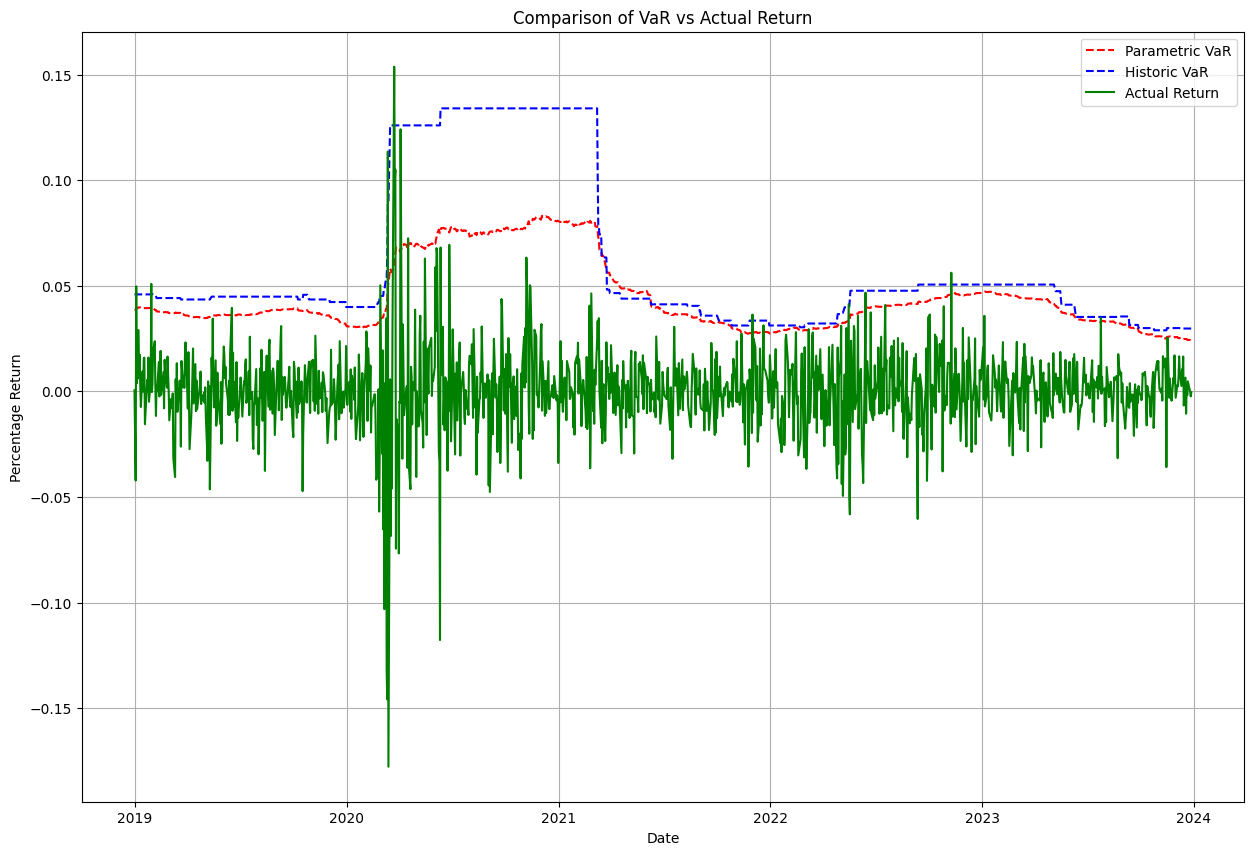

In [ ]:
start_date = '2018-12-31'
end_date = '2023-12-28'
selected_period = pf[(pf['Date'] >= start_date) & (pf['Date'] <= end_date)]

plt.figure(figsize=(15,10))
plt.plot(selected_period['Date'], -selected_period['VaR_99_Param'], 'r--', label='Parametric VaR')
plt.plot(selected_period['Date'], -selected_period['VaR_99_Hist'], 'b--', label="Historic VaR")
plt.plot(selected_period['Date'], selected_period['arth_return_nextday'], 'g-', label='Actual Return')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Percentage Return')
plt.legend()
plt.title('Comparison of VaR vs Actual Return')
plt.show()

Unconditional Testing


In [ ]:
start_date = '2019-01-01'
end_date = '2023-12-29'
pf_copy = pf[(pf['Date'] >= start_date) & (pf['Date'] <= end_date)].copy()

In [ ]:
def unconditional_test(df, col_name, alpha):
    """A function that conducts the Unconditional Test.
    Takes in the dataframe, and the name of the column that is to be tested in the dataframe.
    Dataframe must contain the column with arithmetic returns the next day, named 'arth_return_nextday'. """
    observed_level = 1 - len(df[df[col_name]>df['arth_return_nextday']])/len(df)
    observations = len(df)
    failures = len(df[df[col_name]> df['arth_return_nextday']])
    expected = observations*alpha
    ratio = failures/expected

    p = 1-binom.cdf(failures-1, observations, alpha)
    print(f"P-value of {col_name} VaR 99%: ", p)
    if(p < alpha):
        print("Reject null hypothesis under binomial distribution")
    else:
        print(f"Not enough evidence to reject null at {alpha} backtesting significance level under binomial distribution ")

    return p

In [ ]:
unconditional_test(pf_copy, 'VaR_99_Hist', backtesting_alpha)

P-value of VaR_99_Hist VaR 99%:  0.03161923594161642
Not enough evidence to reject null at 0.01 backtesting significance level under binomial distribution 


0.03161923594161642

In [ ]:
unconditional_test(pf_copy, 'VaR_99_Param', backtesting_alpha)

P-value of VaR_99_Param VaR 99%:  7.33613905168351e-06
Reject null hypothesis under binomial distribution


7.33613905168351e-06

Independence Testing

In [ ]:
def independence_test(df, col_name):
    """A function that conducts the Independence Test.
    Takes in the dataframe, and the name of the column that is to be tested in the dataframe.
    Dataframe must contain the column with arithmetic returns the next day, named 'arth_return_nextday'. """

    df['ind_t'] = df.apply(lambda row: 1 if row[col_name]>row['arth_return_nextday'] else 0, axis=1)
    df['ind_t1'] = df['ind_t'].shift(1)

    # 'ind_00' — indicate periods with no failures followed by a period with no failures
    # 'ind_10' — indicate periods with failures followed by a period with no failures
    # 'ind_01' — indicate periods with no failures followed by a period with failures
    # 'ind_11' — indicate periods with failures followed by a period with failures
    df['ind_00'] = df.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
    df['ind_10'] = df.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
    df['ind_01'] = df.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
    df['ind_11'] = df.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

    # Drop missing values
    df.dropna(inplace=True)

    # 'N00' — Number of periods with no failures followed by a period with no failures
    # 'N10' — Number of periods with failures followed by a period with no failures
    # 'N01' — Number of periods with no failures followed by a period with failures
    # 'N11' — Number of periods with failures followed by a period with failures
    N00, N10, N01, N11 = df[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)

    # p01 = Probability of having a failure on period t, given that there was no failure on period t–1
    # p11 = Probability of having a failure on period t, given that there was a failure on period t–1

    p01 = N01 / (N00 + N01)
    p11 = N11 / (N10 + N11)

    pTotal = (N01 + N11) / (N00 + N01 + N10 + N11)
    z = (p01 - p11) / (sqrt(pTotal * (1 - pTotal) * (1 / (N11+N01) + 1/(N00+N10))))
    p = 1 - norm.cdf(z)

    print(f"Z-score for 99% VaR ({col_name}) {z}")
    print(f"P-value for 99% VaR ({col_name}) {p}")

    return p, z

In [ ]:
# Independence test of Historic VaR 99%
pf_indt = deepcopy(pf_copy)

independence_test(pf_indt, 'VaR_99_Hist')

Z-score for 99% VaR (VaR_99_Hist) -4.828568936406341
P-value for 99% VaR (VaR_99_Hist) 0.9999993124113559


(0.9999993124113559, -4.828568936406341)

In [ ]:
# Independence test of Parametric VaR 99%
pf_indt = deepcopy(pf_copy)

independence_test(pf_indt,'VaR_99_Param')

Z-score for 99% VaR (VaR_99_Param) -3.8207170417624394
P-value for 99% VaR (VaR_99_Param) 0.9999334678767114


(0.9999334678767114, -3.8207170417624394)

**Exception in Graph**

Generally, there are not many significant exceptions for Historic VaR, and most are only about 1% more. For Parametric VaR, there tends to be a bit more exceptions as compared to Historic VaR.

 The most significant exception generated on the graph occured a little into 2020, indicated by the large volatility in Actual Return, and this caused both the parametric and historic VaR to struggle with accurate predictions, causing many more exceptions where losses > VaR. In this case, VaR underestimated the potential losses of the portfolio

**Conclusion from Results**

For Historic VaR, p-value under unconditional testing is 0.03161923594161642 > 0.01. There is insufficient evidence to reject the null hypothesis that the portfolio losses do not exceed the VaR. For independence test, p-value is 0.9999993124113559 > 0.01. Therefore, there is also insufficient evidence to reject null hypothesis that the returns are independent of each other.

For Parametric VaR, p-value under unconditional testing is 7.33613905168351e-06 < 0.01. There is sufficient evidence to reject the null hypothesis that the portfolio losses do not exceed the VaR. For independence test, p-value is 0.0.9999334678767114 > 0.01. Therefore, there is insufficient evidence to reject null hypothesis that the returns are independent of each other.

## Bootstrap Sampling


A possible issue with historic simulation is that the past distributions of returns will hold true for the future which might not be true during market disruptions. One possible way to improve is to do bootstrap sampling.

In [ ]:
from math import exp

def var_99(data):
    return np.percentile(data, 1)

def bootstrap(data, func):
    sample = np.random.choice(data, len(data))
    return func(sample)

def draw_bs_reps(data, func, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap(data, func)
    return bs_replicates


for i in range(0, len(pf)):
    past_250 = pf.loc[(i-249):(i), 'Log Return']
    past_250.dropna(inplace=True)
    if len(past_250) == 250:
        bootstrap_VaR = np.mean(draw_bs_reps(past_250, var_99, 100))
        ES = past_250[past_250 <= bootstrap_VaR].mean()
        pf.loc[i, 'VaR_99_Hist_Bs'] = bootstrap_VaR
        pf.loc[i, 'VaR_99_Hist_Bs_Arith'] = exp(bootstrap_VaR) - 1
        pf.loc[i, 'ES_99_Hist_Bs'] = ES
        pf.loc[i, 'ES_99_Hist_Bs_Arith'] = exp(ES) - 1
    else:
        pf.loc[i, 'VaR_99_Hist_Bs'] = np.NaN
        pf.loc[i, 'VaR_99_Hist_Bs_Arith'] = np.NaN
        pf.loc[i, 'ES_99_Hist_Bs'] = np.NaN
        pf.loc[i, 'ES_99_Hist_Bs_Arith'] = np.NaN


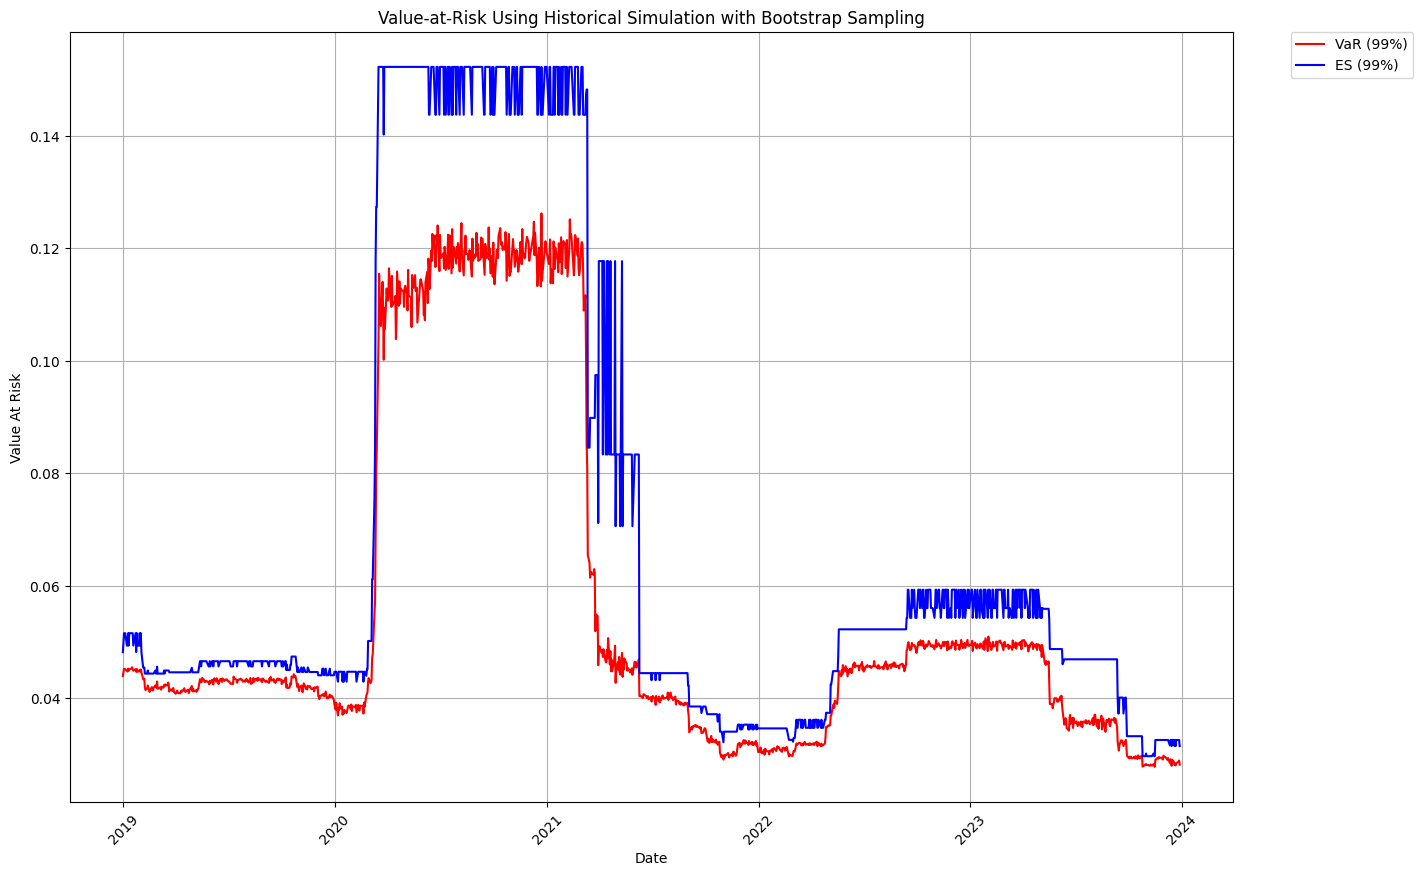

In [ ]:
fitlered_period_hs_bs = pf[(pf["Date"] >= "2018-12-31") & (pf["Date"] <= "2023-12-28")]

# Plot VaR_99
plt.figure(figsize=(15,10))
plt.plot(fitlered_period_hs_bs['Date'], -fitlered_period_hs_bs['VaR_99_Hist_Bs_Arith'], 'r', label='VaR (99%)')
plt.plot(fitlered_period_hs_bs['Date'], -fitlered_period_hs_bs['ES_99_Hist_Bs_Arith'], 'b', label='ES (99%)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk Using Historical Simulation with Bootstrap Sampling')
plt.show()

In [ ]:
print(f"Date: {fitlered_period_hs_bs['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"VaR: {fitlered_period_hs_bs['VaR_99_Hist_Bs_Arith'].iloc[-1]}")
print(f"ES: {fitlered_period_hs_bs['ES_99_Hist_Bs_Arith'].iloc[-1]}")

Date: 2023-12-28
VaR: -0.028215951997554
ES: -0.03152785381158918


In [ ]:
unconditional_test(fitlered_period_hs_bs, "VaR_99_Hist_Bs_Arith", backtesting_alpha)

P-value of VaR_99_Hist_Bs_Arith VaR 99%:  0.03161923594161642
Not enough evidence to reject null at 0.01 backtesting significance level under binomial distribution 


0.03161923594161642

In [ ]:
hist = deepcopy(pf)
hist = hist[(hist["Date"] >= "2019-01-01") & (hist["Date"] <= "2023-12-29")]
independence_test(hist, "VaR_99_Hist_Bs")

Z-score for 99% VaR (VaR_99_Hist_Bs) -4.828568936406341
P-value for 99% VaR (VaR_99_Hist_Bs) 0.9999993124113559


(0.9999993124113559, -4.828568936406341)

**Suggesting possible improvement to historical simulation**

A possible issue with historic simulation is that the past distributions of returns will hold true for the future which might not be true during market disruptions. A possible improvement to historical simulation would be to use bootstrap sampling to reduce sampling bias.

**Discuss results for historic var**

For Historic VaR with bootstrap sampling, p-value under unconditional testing is 0.00970049675437612 < 0.01. There is sufficient evidence to reject the null hypothesis that the portfolio losses do not exceed the VaR. For independence test, p-value is 0.9999993124113559 > 0.01. Therefore, there is insufficient evidence to reject null hypothesis that the returns are independent of each other.

It arrived at a different conclusion for unconditional testing compared to the Historic VaR. This could be because the one with bootstrap sampling captures tail distribution. It is important to note that bootstrap sampling does not necessarily improve the VaR backtesting but provides a more nuanced view.


In [ ]:
# Adopting student's t-distribution for parametric approach

def compute_var_es_portfolio_with_t_distribution(df, sd, mean, weights, alpha = alpha):
    # calculating degrees of freedom, v
    v = len(df) - 1

    # Calculating volatility
    volatility = sd * sqrt((v - 2) / v)

    # Calculating VaR and ES
    z_alpha = t.ppf(alpha, df = v, loc=0, scale=1)
    var = mean + volatility * z_alpha
    es = mean - volatility / alpha * t.pdf(z_alpha, df=v)
    # in log returns
    return var, es

In [ ]:
portfolio_parametric_t = deepcopy(pf)
# For each row, previous 250 rows' (return series) are used to calculate VaR.
for i in range(0, len(portfolio_parametric_t)):
    past_250 = portfolio_parametric_t.loc[(i-249):(i)]
    weights = get_weights(past_250)
    mean = get_mean(past_250, weights)
    sd = get_past_250_sd(past_250, weights)
    if len(past_250) == 250:
        portfolio_parametric_t.loc[i, 'Var_99_Param'], portfolio_parametric_t.loc[i, "ES_99_Param"] = compute_var_es_portfolio_with_t_distribution(past_250, sd, mean, weights)
        portfolio_parametric_t.loc[i, 'Var_99_Param_Arithmetic'] = exp(portfolio_parametric_t.loc[i, 'Var_99_Param']) - 1
        portfolio_parametric_t.loc[i, 'ES_99_Param_Arithmetic'] = exp(portfolio_parametric_t.loc[i, 'ES_99_Param']) - 1
    else:
        portfolio_parametric_t.loc[i, 'Var_99_Param'] = np.NaN
        portfolio_parametric_t.loc[i, 'ES_99_Param'] = np.NaN
        portfolio_parametric_t.loc[i, 'Var_99_Param_Arithmetic'] = np.NaN
        portfolio_parametric_t.loc[i, 'ES_99_Param_Arithmetic'] = np.NaN


<ipython-input-306-6688af0ea7c4>:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  vcv = np.cov(val.T)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


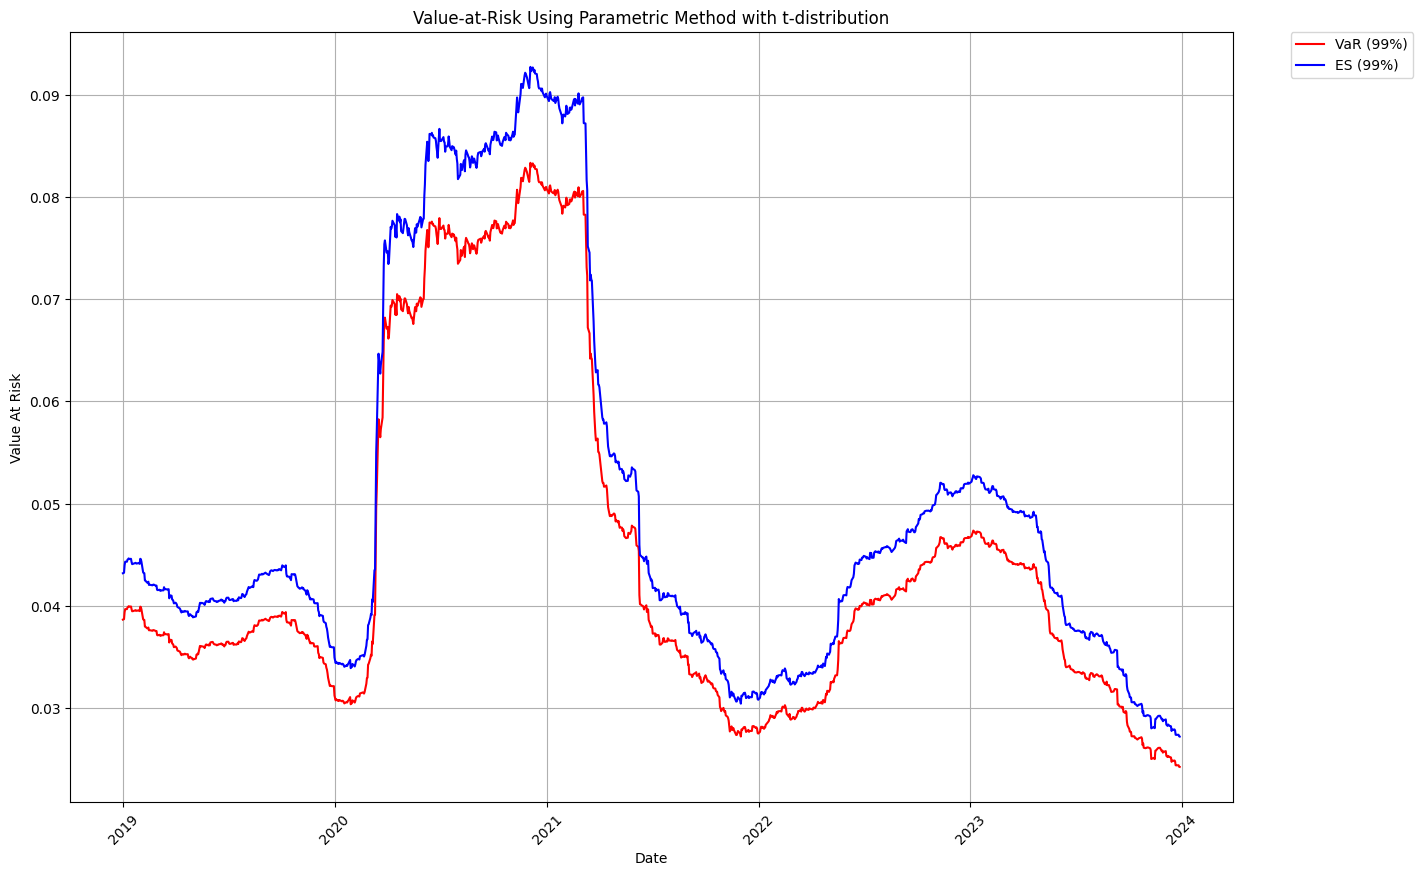

In [ ]:
portfolio_parametric_t.dropna(inplace=True)

# Filter for specificed period
fitlered_period_parametric_t = portfolio_parametric_t[(portfolio_parametric_t["Date"] >= "2018-12-31") & (portfolio_parametric_t["Date"] <= "2023-12-28")]
# Plot VaR_99
plt.figure(figsize=(15,10))
plt.plot(fitlered_period_parametric_t['Date'], -fitlered_period_parametric_t['Var_99_Param_Arithmetic'], 'r', label='VaR (99%)')
plt.plot(fitlered_period_parametric_t['Date'], -fitlered_period_parametric_t['ES_99_Param_Arithmetic'], 'b', label='ES (99%)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk Using Parametric Method with t-distribution')
plt.show()

In [ ]:
print(f"Date: {fitlered_period_parametric_t['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"VaR: {fitlered_period_parametric_t['Var_99_Param_Arithmetic'].iloc[-1]}")
print(f"ES: {fitlered_period_parametric_t['ES_99_Param_Arithmetic'].iloc[-1]}")

Date: 2023-12-28
VaR: -0.02424412143628696
ES: -0.027209196517529732


In [ ]:
unconditional_test(fitlered_period_parametric_t, "Var_99_Param_Arithmetic", backtesting_alpha)

P-value of Var_99_Param_Arithmetic VaR 99%:  7.33613905168351e-06
Reject null hypothesis under binomial distribution


7.33613905168351e-06

In [ ]:
# Conducting Independent Test on the Parametric Method using t-distribution
parametric = deepcopy(portfolio_parametric_t)
parametric = parametric[(parametric["Date"] >= "2019-01-01") & (parametric["Date"] <= "2023-12-29")]
independence_test(parametric, "VaR_99_Param")

Z-score for 99% VaR (VaR_99_Param) -3.8207170417624394
P-value for 99% VaR (VaR_99_Param) 0.9999334678767114


(0.9999334678767114, -3.8207170417624394)

**Suggesting possible improvement to parametric approach**

A possible improvement to the parametric approach would be to use the t-distribution as an alternative to the normal distribution, as there is a possibility that the normal distribution assumption is violated. Hence, the t-distribution allows for a more generalized approach.

**Discuss results for parametric var**

For Parametric VaR with t-distribution, p-value under unconditional testing is 7.33613905168351e-06 < 0.01. There is sufficient evidence to reject the null hypothesis that the portfolio losses do not exceed the VaR. For independence test, p-value is 0.9999334678767114 > 0.01. Therefore, there is insufficient evidence to reject null hypothesis that the returns are independent of each other.

Ultimately, it arrived at the same conclusion as did the parametric VaR with the normal distribution. This implies that the choice of distribution has little impact. Hence the occurrences of exceptions between actual losses and VaR remains statistically insignificant with regards to the differences in distribution


## Portfolio Construction


In [ ]:
def get_data_for_multiple_stocks(tickers, start_date='2019-03-20', end_date='2024-02-01'):
    stocks = dict()
     # initialise output dataframes
    returns_df = pd.DataFrame()
    prices_df = pd.DataFrame() # stores the adj close price of each stock

    # Loop through all the tickers
    for ticker in tickers:
        # Fetch the historical market data using yfinance
        data = yf.download(ticker, start=start_date, end=end_date)

        # Adding a 'Ticker' column for reference
        data.insert(0, 'Ticker', ticker)

        # Calculate previous close, log returns, and percentage returns
        data['Prev Close'] = data['Adj Close'].shift(1)
        data['log_return'] = np.log(data['Adj Close'] / data['Prev Close'])

        returns_df[ticker] = data['log_return'] #data is merely an intermediate placeholder, we are only interested in the return series of the stocks.

        prices_df[ticker] = data["Adj Close"]

    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days

    returns_df = returns_df.iloc[1:].fillna(0)


    return returns_df, prices_df

In [ ]:
tickers = ["MMM", "AXP", "AMGN", "AMZN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "DOW", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "VZ", "V", "WMT"]
returns_df, prices_df = get_data_for_multiple_stocks(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
simple_returns = np.exp(returns_df) -1
# Splitting into train test set


in_sample = "2022-02-02" #cut off for train set
is_returns_df = simple_returns.loc[:in_sample] # Train Set
oos_returns_df = simple_returns.loc[in_sample:][1:] # Test set

In [ ]:
# Calculate expected returns and sample covariance using PyPortfolioOpt’s built-in methods
mu = expected_returns.mean_historical_return(is_returns_df, returns_data=True) # Expected Return
S = risk_models.sample_cov(is_returns_df, returns_data=True) # Covariance Matrix
print(is_returns_df)
print(mu)

                 MMM       AXP      AMGN      AMZN      AAPL        BA  \
Date                                                                     
2019-03-21  0.006289  0.009479  0.004029  0.012235  0.036830 -0.009198   
2019-03-22 -0.023616 -0.021105 -0.027047 -0.029952 -0.020708 -0.028253   
2019-03-25 -0.007085 -0.003837 -0.000589  0.005377 -0.012091  0.022890   
2019-03-26  0.019832  0.004219  0.009004  0.005354 -0.010332 -0.000216   
2019-03-27 -0.000386 -0.004749 -0.010358 -0.010125  0.008994  0.010341   
...              ...       ...       ...       ...       ...       ...   
2022-01-27  0.005080 -0.019507  0.006561  0.005509 -0.002943 -0.023267   
2022-01-28 -0.041491  0.030017  0.022946  0.031084  0.069778  0.004322   
2022-01-31  0.017903  0.015588 -0.008728  0.038864  0.026126  0.050742   
2022-02-01  0.008493  0.020687  0.006780  0.010831 -0.000973  0.040451   
2022-02-02 -0.004599  0.003378  0.001093 -0.003843  0.007044 -0.003936   

                 CAT       CVX      C

### Computing Portfolio Metrics

In [ ]:
risk_free_rate = 0.0410 # current 10 Year Treasury Rate in US

# used for evaluating the portfolio
def compute_portfolio_performance_metrics(weights, expected_returns, cov_matrix):
    weights = np.array(list(weights.values()))

    portfolio_return = np.sum(weights * expected_returns)

    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

    # Compute Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility


    return portfolio_return, portfolio_volatility, sharpe_ratio

Benchmark: DJIA ETF, DIA

In [ ]:
# using DJIA ETF, DIA as benchmark
dia = yf.download("DIA", start=start_date, end=end_date)
dia["Prev Close"] = dia["Adj Close"].shift(1)
dia["Log Return"] = np.log((dia["Adj Close"] / dia["Prev Close"]))
dia.dropna(inplace=True)

benchmark = dia["Log Return"]

[*********************100%%**********************]  1 of 1 completed


### Models

Model 1: Risk Aversion Model

In [ ]:
ef = EfficientFrontier(mu, S)

optimal_weights_portfolio_high_risk_aversion = ef.max_quadratic_utility(risk_aversion=20)
returns, volatility, sharpe = compute_portfolio_performance_metrics(optimal_weights_portfolio_high_risk_aversion, mu, S)

weights_series = round(pd.Series(optimal_weights_portfolio_high_risk_aversion), 6)

print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series.iloc[weights_series.to_numpy().nonzero()[0]])

Expected Portfolio Return: 23.66%
Expected Portfolio Volatility: 18.91%
Sharpe Ratio: 1.03
Weights: 
AMZN    0.041105
AAPL    0.235668
CAT     0.003396
KO      0.047906
JNJ     0.074945
MCD     0.034970
NKE     0.017523
PG      0.140491
VZ      0.207872
WMT     0.196124
dtype: float64


Model 2: Max Sharpe Ratio

In [ ]:
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_max_sharpe = ef.max_sharpe()

returns, volatility, sharpe = compute_portfolio_performance_metrics(optimal_weights_portfolio_max_sharpe, mu, S)

weights_series = round(pd.Series(optimal_weights_portfolio_max_sharpe), 6)

print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series.iloc[weights_series.to_numpy().nonzero()[0]])

Expected Portfolio Return: 58.46%
Expected Portfolio Volatility: 33.48%
Sharpe Ratio: 1.62
Weights: 
AAPL    0.971986
PG      0.028014
dtype: float64


Model 3: Prioritizing Divident Yield

In [ ]:
sector_mapper = {
    "VZ": "High",
    "MMM": "High",
    "DJI": "High",
    "CVX": "High",
    "IBM": "High",
    "AMGN": "High",
    "KO": "High",
    "GS": "High",
    "CSCO": "High",
    "JNJ": "High",
    "MRK": "High",
    "MCD": "High",
    "HD": "High",
    "PG": "High",
    "JPM": "High",
    "HON": "High",
    "TRV": "Medium",
    "UNH": "Medium",
    "CAT": "Medium",
    "NKE": "Medium",
    "WMT": "Medium",
    "AXT": "Medium",
    "INTC": "Medium",
    "DIS": "Medium",
    "V": "Low",
    "MSFT": "Low",
    "AAPL": "Low",
    "CRM": "Low",
}

sector_lower = {"Low": 0.1, "Medium": 0.3, "High": 0.5}
sector_upper = {
    "Low": 0.3,
    "Medium": 0.5,
    "High": 0.7
}

ef_sector_constraints = EfficientFrontier(mu, S)
ef_sector_constraints.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef_sector_constraints.add_constraint(lambda x : x >= 0.01)
optimal_weights_portfolio_divident_yield = ef_sector_constraints.max_quadratic_utility(risk_aversion=10)

returns, volatility, sharpe = compute_portfolio_performance_metrics(optimal_weights_portfolio_divident_yield, mu, S)

weights_series = round(pd.Series(optimal_weights_portfolio_divident_yield), 6)

print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series.iloc[weights_series.to_numpy().nonzero()[0]])

Expected Portfolio Return: 23.39%
Expected Portfolio Volatility: 20.42%
Sharpe Ratio: 0.94
Weights: 
MMM     0.010000
AXP     0.010000
AMGN    0.010000
AMZN    0.010000
AAPL    0.130000
BA      0.010000
CAT     0.010000
CVX     0.010000
CSCO    0.010000
KO      0.010000
DIS     0.010000
DOW     0.010000
GS      0.010000
HD      0.087019
HON     0.010000
IBM     0.010000
INTC    0.010000
JNJ     0.010000
JPM     0.010000
MCD     0.010000
MRK     0.010000
MSFT    0.010000
NKE     0.016028
PG      0.282981
CRM     0.010000
TRV     0.010000
UNH     0.029322
VZ      0.010000
V       0.010000
WMT     0.214650
dtype: float64


Model 4: Diversified Portfolio (Using basic Covariance)

In [ ]:
from cvxpy import *

ef_diversified = EfficientFrontier(mu, S)
ef_diversified.add_constraint(lambda x: x <= 0.2)
ef_diversified.add_constraint(lambda x : x >= 0.01)
ef_diversified.add_constraint(lambda x: quad_form(x, S) <= 0.05)
ef_diversified_results = ef_diversified.max_quadratic_utility(risk_aversion=10)


returns, volatility, sharpe = compute_portfolio_performance_metrics(ef_diversified_results, mu, S)

weights_series = round(pd.Series(ef_diversified_results), 6)

print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series.iloc[weights_series.to_numpy().nonzero()[0]])

Expected Portfolio Return: 29.28%
Expected Portfolio Volatility: 22.13%
Sharpe Ratio: 1.14
Weights: 
MMM     0.010000
AXP     0.010000
AMGN    0.010000
AMZN    0.010000
AAPL    0.200000
BA      0.010000
CAT     0.010000
CVX     0.010000
CSCO    0.010000
KO      0.010000
DIS     0.010000
DOW     0.010000
GS      0.010000
HD      0.010000
HON     0.010000
IBM     0.010000
INTC    0.010000
JNJ     0.010000
JPM     0.010000
MCD     0.010000
MRK     0.010000
MSFT    0.183851
NKE     0.010000
PG      0.200000
CRM     0.010000
TRV     0.010000
UNH     0.010000
VZ      0.010000
V       0.010000
WMT     0.156149
dtype: float64


Model 5: Sector Constraints, Maximise Quadratic Utility with High Risk Aversion

In [ ]:
sector_mapper = {
    "MMM": "conglomerate",
    "AXP": "finance",
    "AMGN": "biopharmaceutical",
    "AMZN": "retailing",
    "AAPL": "it",
    "BA": "aerospace",
    "CAT": "construction",
    "CVX": "petroleum",
    "CSCO": "it",
    "KO": "food_beverage",
    "DIS": "entertainment",
    "DOW": "chemical",
    "GS": "finance",
    "HD": "home",
    "HON": "conglomerate",
    "IBM": "it",
    "INTC": "semiconductor",
    "JNJ": "pharmaceutical",
    "JPM": "finance",
    "MCD": "food_beverage",
    "MRK": "pharmaceutical",
    "MSFT": "it",
    "NKE": "clothing",
    "PG": "fast_moving_consumer",
    "CRM": "it",
    "TRV": "insurance",
    "UNH": "healthcare",
    "VZ": "telecommunications",
    "V": "finance",
    "WMT": "retailing",
}

sector_lower = {"it": 0.1, "finance": 0.1}
sector_upper = {"it": 0.7, "finance": 0.2}

In [ ]:
# Optimise for Mmax quadratic utility, risk aversion coefficient = 20, with sector constraints
ef_sector_constraints = EfficientFrontier(mu, S)
ef_sector_constraints.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
optimal_weights_portfolio_high_risk_aversion_sector = ef_sector_constraints.max_quadratic_utility(risk_aversion=20)

returns, volatility, sharpe = compute_portfolio_performance_metrics(optimal_weights_portfolio_high_risk_aversion_sector, mu, S)

weights_series = pd.Series(optimal_weights_portfolio_high_risk_aversion_sector)

print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series.iloc[weights_series.to_numpy().nonzero()[0]])

Expected Portfolio Return: 23.68%
Expected Portfolio Volatility: 19.31%
Sharpe Ratio: 1.01
Weights: 
AMZN    0.044891
AAPL    0.211156
KO      0.022073
GS      0.078515
JNJ     0.072521
MCD     0.004846
PG      0.149096
VZ      0.192219
V       0.021485
WMT     0.203197
dtype: float64


Model 6: Hierarchical Risk Parity

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt
hrp = HRPOpt(simple_returns, S)
hrp_port = hrp.optimize()
returns, volatility, sharpe = compute_portfolio_performance_metrics(hrp_port, mu, S)
weights_series = pd.Series(hrp_port)
print(f"Expected Portfolio Return: {round(returns * 100, 2)}%")
print(f"Expected Portfolio Volatility: {round(volatility * 100, 2)}%")
print(f"Sharpe Ratio: {round(sharpe, 2)}")
print("Weights: ")
print(weights_series)

Expected Portfolio Return: 15.33%
Expected Portfolio Volatility: 23.35%
Sharpe Ratio: 0.48
Weights: 
AAPL    0.021972
AMGN    0.043243
AMZN    0.020275
AXP     0.013088
BA      0.019491
CAT     0.018580
CRM     0.016799
CSCO    0.035274
CVX     0.027816
DIS     0.021875
DOW     0.013670
GS      0.016868
HD      0.031301
HON     0.025681
IBM     0.035751
INTC    0.016225
JNJ     0.065108
JPM     0.017452
KO      0.049191
MCD     0.046744
MMM     0.044598
MRK     0.051698
MSFT    0.024125
NKE     0.025527
PG      0.048504
TRV     0.025419
UNH     0.036446
V       0.026645
VZ      0.095978
WMT     0.064654
dtype: float64


### Evaluation

#### Discrete Allocation

In [ ]:
is_prices_df = prices_df.loc[:in_sample] # Train Set
oos_prices_df = prices_df.loc[in_sample:][1:] # Test Set
# Obtain latest prices
latest_prices = get_latest_prices(is_prices_df)

In [ ]:
def get_market_value_of_stocks(price_values, no_of_shares_dict):
    market_value = 0
    price_dict = price_values.to_dict()
    for key in price_dict:
        if(key not in no_of_shares_dict):
            continue #not allocated, let's pass it.
        market_value += (price_dict[key] * no_of_shares_dict[key])

    return market_value

In [ ]:
oos_portfolio = oos_prices_df

In [ ]:
optimal_weights_portfolio_high_risk_aversion_dict  = pd.Series(optimal_weights_portfolio_high_risk_aversion, index = is_returns_df.columns).to_dict()
optimal_weights_portfolio_max_sharpe_dict = pd.Series(optimal_weights_portfolio_max_sharpe, index = is_returns_df.columns).to_dict()
ef_diversified_results_dict = pd.Series(ef_diversified_results, index = is_returns_df.columns).to_dict()
optimal_weights_portfolio_divident_yield_dict = pd.Series(optimal_weights_portfolio_divident_yield, index = is_returns_df.columns).to_dict()
optimal_weights_portfolio_high_risk_aversion_sector_dict = pd.Series(optimal_weights_portfolio_high_risk_aversion_sector, index = is_returns_df.columns).to_dict()
optimal_weights_portfolio_hierachical_dict = pd.Series(hrp_port, index = is_returns_df.columns).to_dict()

In [ ]:
da_high_risk_aversion = DiscreteAllocation(optimal_weights_portfolio_high_risk_aversion_dict, latest_prices, total_portfolio_value=20000)
allocation_high_risk_aversion, leftover_high_risk_aversion = da_high_risk_aversion.lp_portfolio()

da_max_sharpe = DiscreteAllocation(optimal_weights_portfolio_max_sharpe_dict, latest_prices, total_portfolio_value=20000)
allocation_max_sharpe_aversion, leftover_max_sharpe = da_max_sharpe.lp_portfolio()

da_ef_diversified_results = DiscreteAllocation(ef_diversified_results_dict, latest_prices, total_portfolio_value=20000)
allocation_diversified_results, leftover_diversified_results = da_ef_diversified_results.lp_portfolio()

da_divident_yield = DiscreteAllocation(optimal_weights_portfolio_divident_yield_dict , latest_prices, total_portfolio_value=20000)
allocation_divident_yield , leftove_divident_yield = da_divident_yield.lp_portfolio()

da_sector = DiscreteAllocation(optimal_weights_portfolio_high_risk_aversion_sector_dict, latest_prices, total_portfolio_value=20000)
allocation_sector, leftover_sector = da_sector.lp_portfolio()

da_hrp = DiscreteAllocation(optimal_weights_portfolio_hierachical_dict, latest_prices, total_portfolio_value=20000)
allocation_hrp, leftover_hrp  = da_hrp.lp_portfolio()

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
portfolio = simple_returns

portfolio["High_Risk_Aversion Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_high_risk_aversion), axis=1)
portfolio["High_Risk_Aversion Prev Market Value"] = portfolio["High_Risk_Aversion Market Value"].shift(1)
portfolio["High_Risk_Aversion Log Returns"] = np.log(portfolio["High_Risk_Aversion Market Value"]/portfolio["High_Risk_Aversion Prev Market Value"])
portfolio_High_risk_aversion_hold = portfolio["High_Risk_Aversion Log Returns"]

portfolio["Max_Sharpe Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_max_sharpe_aversion), axis=1)
portfolio["Max_Sharpe Prev Market Value"] = portfolio["Max_Sharpe Market Value"].shift(1)
portfolio["Max_Sharpe Log Returns"] = np.log(portfolio["Max_Sharpe Market Value"]/portfolio["Max_Sharpe Prev Market Value"])
portfolio_max_sharpe_hold = portfolio["Max_Sharpe Log Returns"]

portfolio["Diversified_Results Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_diversified_results), axis=1)
portfolio["Diversified_Results Prev Market Value"] = portfolio["Diversified_Results Market Value"].shift(1)
portfolio["Diversified_Results Log Returns"] = np.log(portfolio["Diversified_Results Market Value"]/portfolio["Diversified_Results Prev Market Value"])
portfolio_diversified_results_hold = portfolio["Diversified_Results Log Returns"]

portfolio["Divident_Yield Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_divident_yield), axis=1)
portfolio["Divident_Yield Prev Market Value"] = portfolio["Divident_Yield Market Value"].shift(1)
portfolio["Divident_Yield Log Returns"] = np.log(portfolio["Divident_Yield Market Value"]/portfolio["Divident_Yield Prev Market Value"])
portfolio_divident_yield_hold = portfolio["Divident_Yield Log Returns"]

portfolio["Sector Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_sector), axis=1)
portfolio["Sector Prev Market Value"] = portfolio["Sector Market Value"].shift(1)
portfolio["Sector Log Returns"] = np.log(portfolio["Sector Market Value"]/portfolio["Sector Prev Market Value"])
portfolio_sector_hold = portfolio["Sector Log Returns"]

portfolio["HRP Market Value"] = prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation_hrp), axis=1)
portfolio["HRP Prev Market Value"] = portfolio["HRP Market Value"].shift(1)
portfolio["HRP Log Returns"] = np.log(portfolio["HRP Market Value"]/portfolio["HRP Prev Market Value"])
portfolio_hrp_hold = portfolio["HRP Log Returns"]

In [ ]:
all_portfolio_returns = pd.concat(
    [benchmark, portfolio_sector_hold, portfolio_High_risk_aversion_hold, portfolio_max_sharpe_hold, portfolio_divident_yield_hold, portfolio_diversified_results_hold, portfolio_hrp_hold], axis = 1)
all_portfolio_returns.columns = ["Benchmark", "Portfolio_Sector", "Portfolio_High_Risk_Aversion", "Portfolio_Max_Sharpe", "Portfolio_Divident_Yield", "Portfolio_Diversified_Results","Portfolio_HRP"]

all_portfolio_returns.dropna(inplace=True)

is_results = all_portfolio_returns[:in_sample]
oos_results = all_portfolio_returns[in_sample:][1:] # one day after in_sample date

print(is_results)

            Benchmark  Portfolio_Sector  Portfolio_High_Risk_Aversion  \
Date                                                                    
2019-03-22  -0.017959         -0.001600                      0.000809   
2019-03-25   0.000432          0.000634                      0.000629   
2019-03-26   0.005435          0.006605                      0.006338   
2019-03-27  -0.001366         -0.001347                     -0.000717   
2019-03-28   0.003780         -0.007545                     -0.008186   
...               ...               ...                           ...   
2022-01-27   0.000264          0.001995                      0.002222   
2022-01-28   0.016148          0.029894                      0.030018   
2022-01-31   0.011372          0.013512                      0.013315   
2022-02-01   0.008113          0.003191                      0.000074   
2022-02-02   0.005888          0.007052                      0.008008   

            Portfolio_Max_Sharpe  Portfolio_Divide

##### In Sample Results

In [ ]:
from scipy.stats import norm, binom, t, linregress

# used for evaluation
def compute_metrics(data, alpha=0.01):
    #returns
    daily_arithmetic_returns = np.exp(data) - 1
    returns = daily_arithmetic_returns.mean(axis=0) * 252

    #risk
    sd = np.exp(data.std(axis=0) * len(data) ** 0.5) - 1
    sharpe = data.mean(axis=0) / data.std(axis=0) * len(data) ** 0.5
    #downside deviation
    downside_returns = data[data < 0]
    downside_deviation = np.exp(downside_returns.std(axis=0) * len(data) ** 0.5) - 1

    #sortino Ratio
    sortino_ratio = returns / downside_deviation

    #Use Historic VaR
    sorted_data = data.copy()

    # Sort each column individually
    for column in sorted_data.columns:
      sorted_data[column] = sorted_data[column].sort_values()

    # Calculate the 5th percentile (VaR) for each column
    var_values = sorted_data.quantile(0.01)*-1

    #max drawdown
    cumulative_returns = (1 + data).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    mod_max_drawdown = -max_drawdown

    #calmar Ratio
    calmar_ratio = returns / mod_max_drawdown

    #hpr
    hpr = np.exp(data.sum(axis=0)) - 1

    #beta
    compute_arithmetic = np.exp(data) - 1

    #betas and Treynor's Ratio for each portfolio
    benchmark = compute_arithmetic.iloc[:,0]
    betas = {}
    treynors = {}

    for i in range(1, compute_arithmetic.shape[1]):
        portfolio_returns = compute_arithmetic.iloc[:, i]
        beta = linregress(benchmark, portfolio_returns).slope
        betas[compute_arithmetic.columns[i]] = beta
        treynors[compute_arithmetic.columns[i]] = (returns[i] - risk_free_rate) / beta

    return sd, sharpe, downside_deviation, sortino_ratio, var_values, max_drawdown, calmar_ratio, hpr, betas, treynors

In [ ]:
# DataFrame to consolidate the metrics computed for In Sample
is_metrics = pd.DataFrame()

is_sd_annualised, is_sharpe_annualised, is_downside_deviation, is_sortino_ratio, is_var_parametric_99, is_max_drawdown, is_calmar_ratio, is_hpr, is_beta, is_treynors_ratio = compute_metrics(is_results)
is_metrics["In Sample Portfolio SD"] = is_sd_annualised
is_metrics["In Sample Portfolio Sharpe"] = is_sharpe_annualised
is_metrics["In Sample Portfolio Downside Deviation"] = is_downside_deviation
is_metrics["In Sample Portfolio Sortino Ratio"] = is_sortino_ratio
is_metrics["In Sample Portfolio 99% VaR Historic"] = is_var_parametric_99
is_metrics["In Sample Portfolio Maximum Drawdown"] = is_max_drawdown
is_metrics["In Sample Portfolio Calmar Ratio"] = is_calmar_ratio
is_metrics["In Sample Portfolio Holding Period Return"] = is_hpr
is_metrics["In Sample Portfolio Beta"] = is_beta
is_metrics["In Sample Treynor's Ratio"] = is_treynors_ratio


In [ ]:
is_metrics

,In Sample Portfolio SD,In Sample Portfolio Sharpe,In Sample Portfolio Downside Deviation,In Sample Portfolio Sortino Ratio,In Sample Portfolio 99% VaR Historic,In Sample Portfolio Maximum Drawdown,In Sample Portfolio Calmar Ratio,In Sample Portfolio Holding Period Return,In Sample Portfolio Beta,In Sample Treynor's Ratio
Benchmark,0.498614,0.919186,0.467955,0.337129,0.045719,-0.390307,0.404197,0.450413,NaN,NaN
Portfolio_Sector,0.362819,1.562890,0.298600,0.619957,0.029652,-0.209606,0.883176,0.622229,0.650084,0.221693
Portfolio_High_Risk_Aversion,0.354183,1.552491,0.287101,0.626535,0.029784,-0.203249,0.885018,0.601135,0.616339,0.225329
Portfolio_Max_Sharpe,0.758686,2.269071,0.538904,0.930944,0.056565,-0.339108,1.479437,2.600394,1.001806,0.459859
Portfolio_Divident_Yield,0.403538,1.532327,0.359056,0.559320,0.031367,-0.256238,0.783753,0.681108,0.745847,0.214289
Portfolio_Diversified_Results,0.434443,1.693256,0.382102,0.615862,0.038458,-0.269714,0.872486,0.842064,0.801041,0.242587
Portfolio_HRP,0.402630,0.855949,0.359780,0.335373,0.034703,-0.309796,0.389483,0.335906,0.817072,0.097495


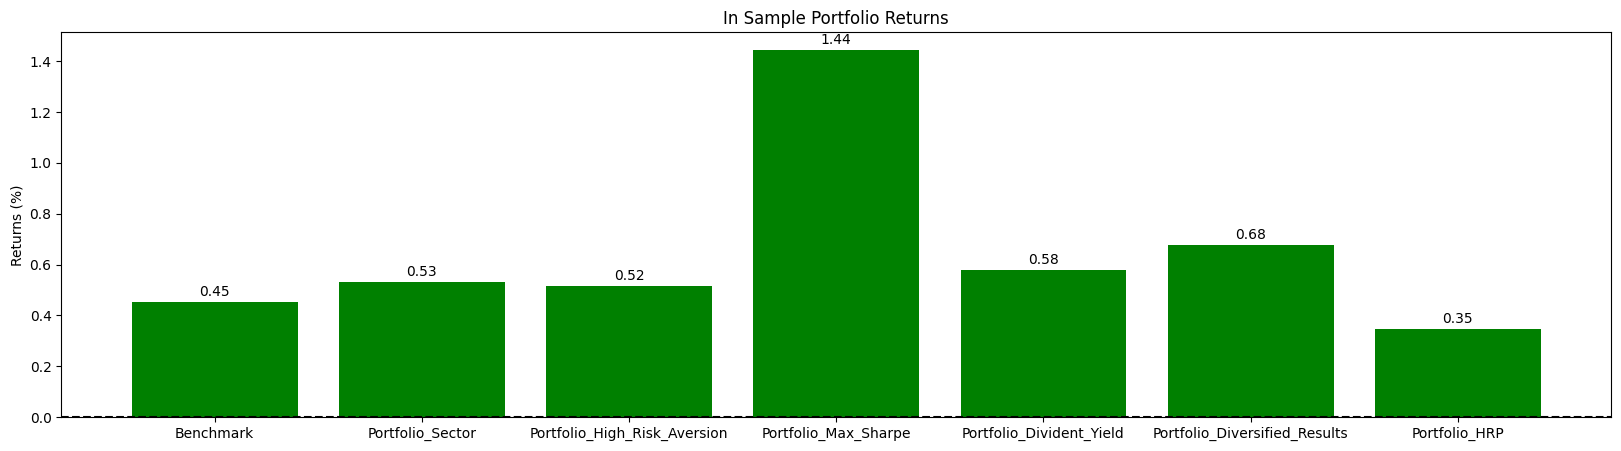

In [ ]:
# plot returns
arithmetic_is_results = np.exp(is_results) - 1
arithmetic_is_results.dropna(inplace = True)
#arithmetic_is_results.expanding(0).apply(lambda x: sum(x) * 100, raw = True, axis=1).plot(figsize = (15, 5))
is_results_plot = arithmetic_is_results.sum(axis=0)
plt.figure(figsize=(20, 5))

bars = plt.bar(is_results_plot.index, is_results_plot.values, color='green')  # Create the bar chart

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.04, f"{yval:.2f}", ha='center', va='center', fontsize=10)

plt.title("In Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

##### Out of Sample Results

In [ ]:
# DataFrame to consolidate the metrics computed for In Sample
oos_metrics = pd.DataFrame()

oos_sd_annualised, oos_sharpe_annualised, oos_downside_deviation, oos_sortino_ratio, oos_var_parametric_99, oos_max_drawdown, oos_calmar_ratio, oos_hpr, oos_beta, oos_treynors_ratio = compute_metrics(oos_results)
oos_metrics["Out of Sample Portfolio SD"] = oos_sd_annualised
oos_metrics["Out of Sample Portfolio Sharpe"] = oos_sharpe_annualised
oos_metrics["Out of Sample Portfolio Downside Deviation"] = oos_downside_deviation
oos_metrics["Out of Sample Portfolio Sortino Ratio"] = oos_sortino_ratio
oos_metrics["Out of Sample Portfolio 99% VaR Historic"] = oos_var_parametric_99
oos_metrics["Out of Sample Portfolio Maximum Drawdown"] = oos_max_drawdown
oos_metrics["Out of Sample Portfolio Calmar Ratio"] = oos_calmar_ratio
oos_metrics["Out of Sample Portfolio Holding Period Return"] = oos_hpr
oos_metrics["Out of Sample Portfolio Beta"] = oos_beta
oos_metrics["Out of Sample Portfolio Treynor's Ratio"] = oos_treynors_ratio

oos_metrics


,Out of Sample Portfolio SD,Out of Sample Portfolio Sharpe,Out of Sample Portfolio Downside Deviation,Out of Sample Portfolio Sortino Ratio,Out of Sample Portfolio 99% VaR Historic,Out of Sample Portfolio Maximum Drawdown,Out of Sample Portfolio Calmar Ratio,Out of Sample Portfolio Holding Period Return,Out of Sample Portfolio Beta,Out of Sample Portfolio Treynor's Ratio
Benchmark,0.251888,0.426434,0.167489,0.380810,0.028438,-0.196428,0.324706,0.100539,NaN,NaN
Portfolio_Sector,0.240642,0.069473,0.160861,0.125086,0.026808,-0.212941,0.094493,0.015093,0.836593,-0.024957
Portfolio_High_Risk_Aversion,0.240544,0.018967,0.163381,0.087944,0.026237,-0.216322,0.066422,0.004097,0.802979,-0.033166
Portfolio_Max_Sharpe,0.479371,0.264988,0.311074,0.305591,0.048706,-0.327552,0.290217,0.109350,1.339093,0.040372
Portfolio_Divident_Yield,0.242293,0.250075,0.165725,0.247249,0.026179,-0.197868,0.207085,0.055755,0.855219,-0.000029
Portfolio_Diversified_Results,0.274012,0.391087,0.182477,0.358164,0.029919,-0.208198,0.313917,0.099340,0.975308,0.024974
Portfolio_HRP,0.214267,0.310777,0.142785,0.292190,0.024643,-0.184603,0.226000,0.062192,0.833196,0.000865


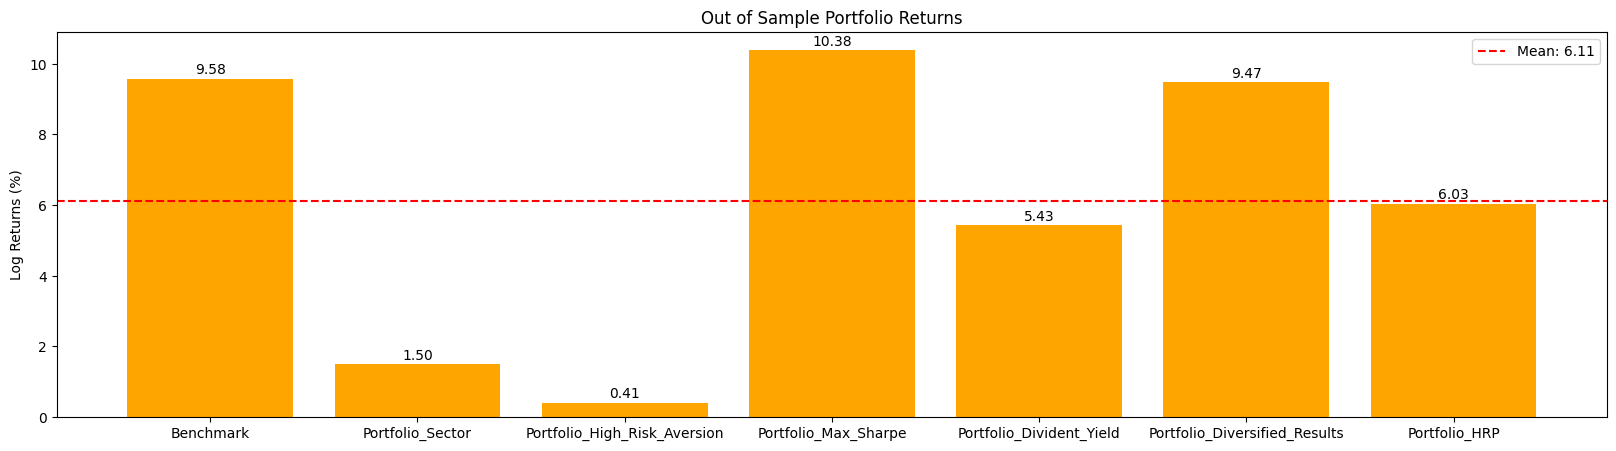

In [ ]:
# oos_results.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
oos_results_plot = oos_results.sum(axis=0) * 100
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_results_plot.values, color='orange')
plt.title("Out of Sample Portfolio Returns")
plt.ylabel("Log Returns (%)")
mean_value = np.mean(oos_results.sum(axis=0)*100)
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.25, f"{yval:.2f}", ha='center', va='center', fontsize=10)

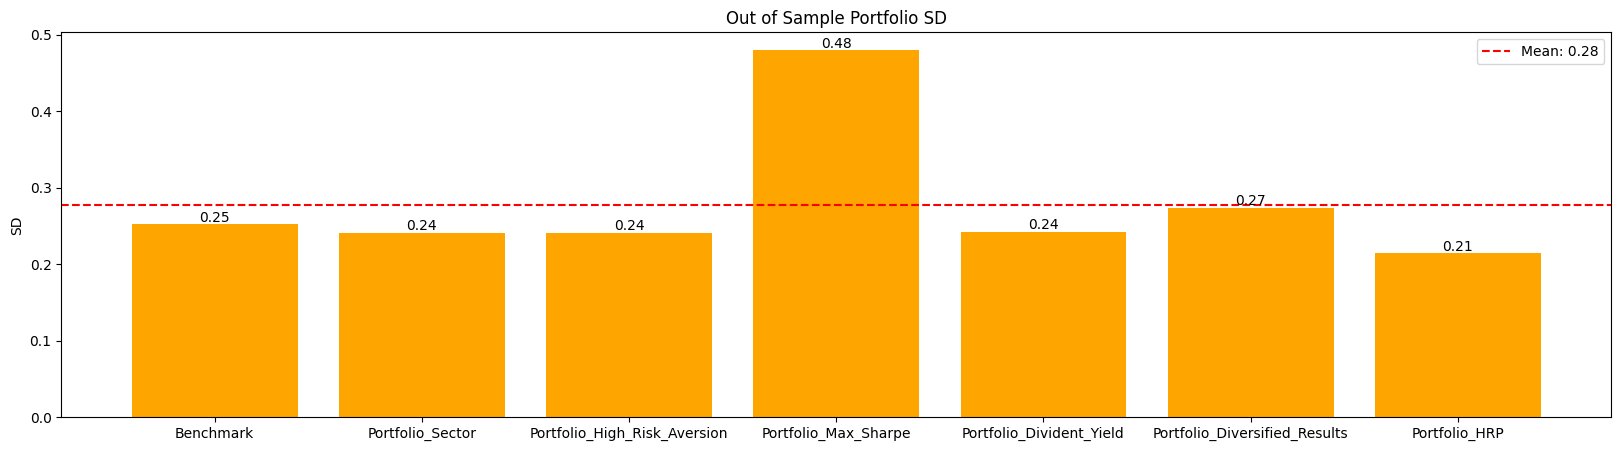

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio SD"], color='orange')
plt.title("Out of Sample Portfolio SD")
plt.ylabel("SD")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio SD"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.009, f"{yval:.2f}", ha='center', va='center', fontsize=10)

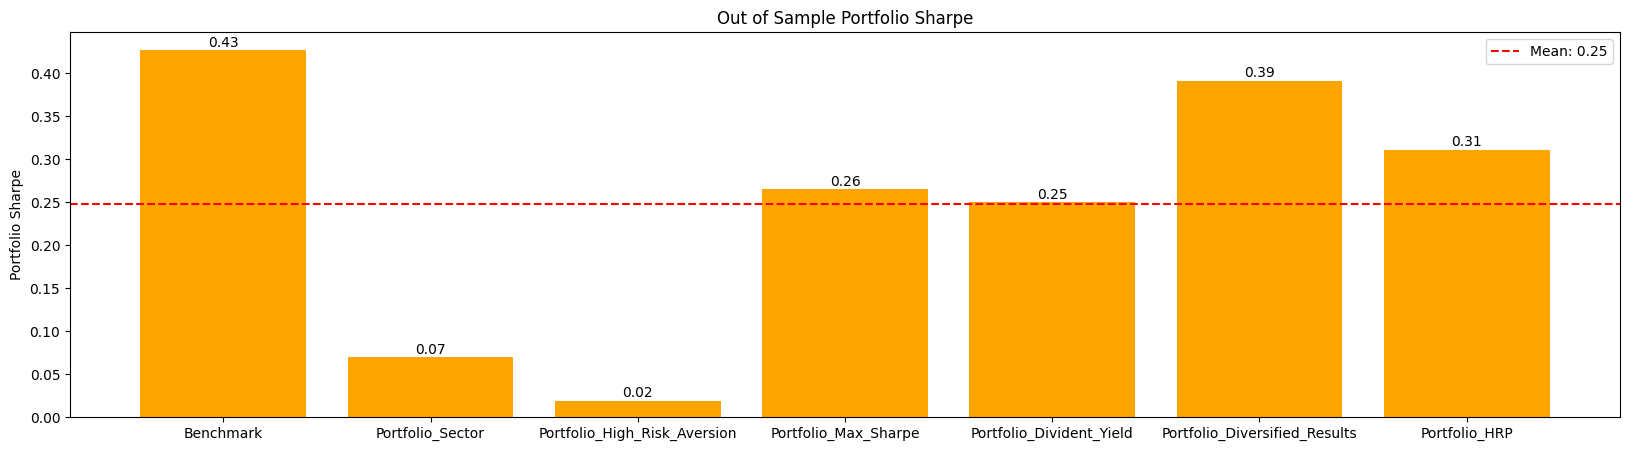

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Sharpe"], color='orange')
plt.title("Out of Sample Portfolio Sharpe")
plt.ylabel("Portfolio Sharpe")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Sharpe"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.009, f"{yval:.2f}", ha='center', va='center', fontsize=10)

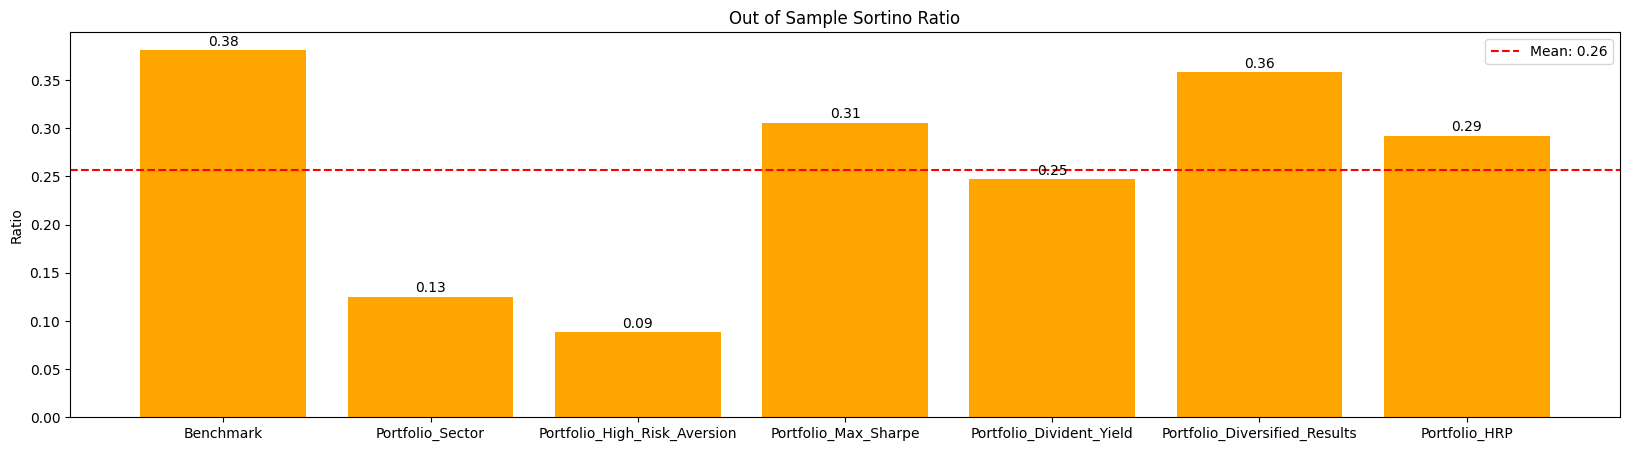

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Sortino Ratio"], color='orange')
plt.title("Out of Sample Sortino Ratio")
plt.ylabel("Ratio")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Sortino Ratio"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.009, f"{yval:.2f}", ha='center', va='center', fontsize=10)

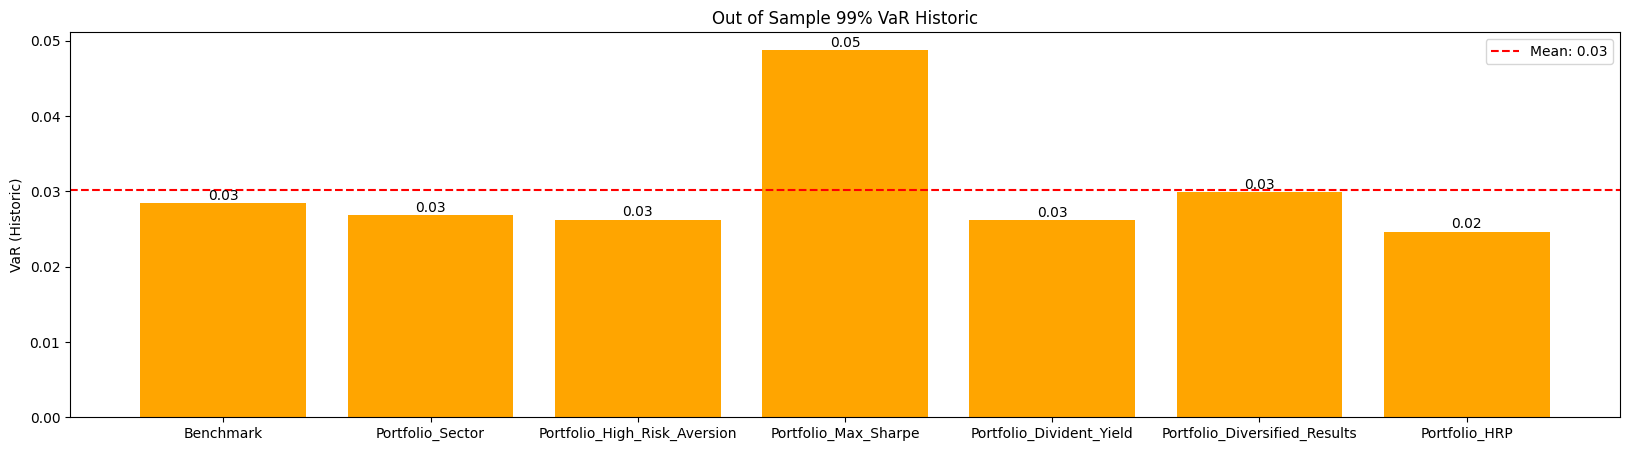

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio 99% VaR Historic"], color='orange')
plt.title("Out of Sample 99% VaR Historic")
plt.ylabel("VaR (Historic)")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio 99% VaR Historic"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.001, f"{yval:.2f}", ha='center', va='center', fontsize=10)

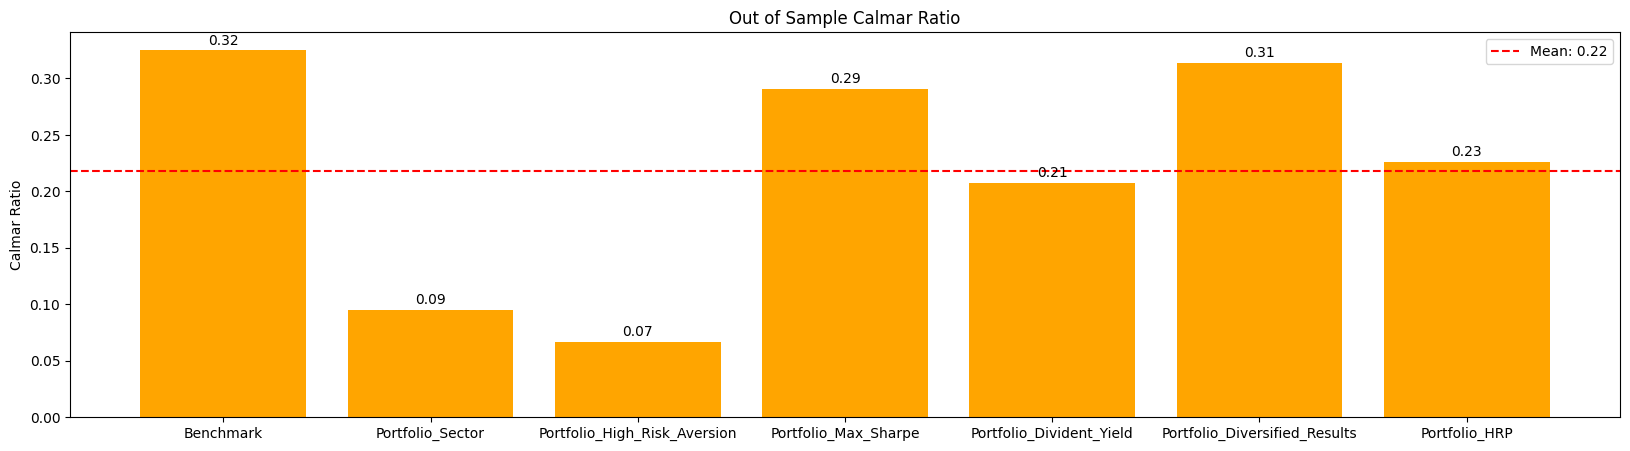

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Calmar Ratio"], color='orange')
plt.title("Out of Sample Calmar Ratio")
plt.ylabel("Calmar Ratio")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Calmar Ratio"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.009, f"{yval:.2f}", ha='center', va='center', fontsize=10)

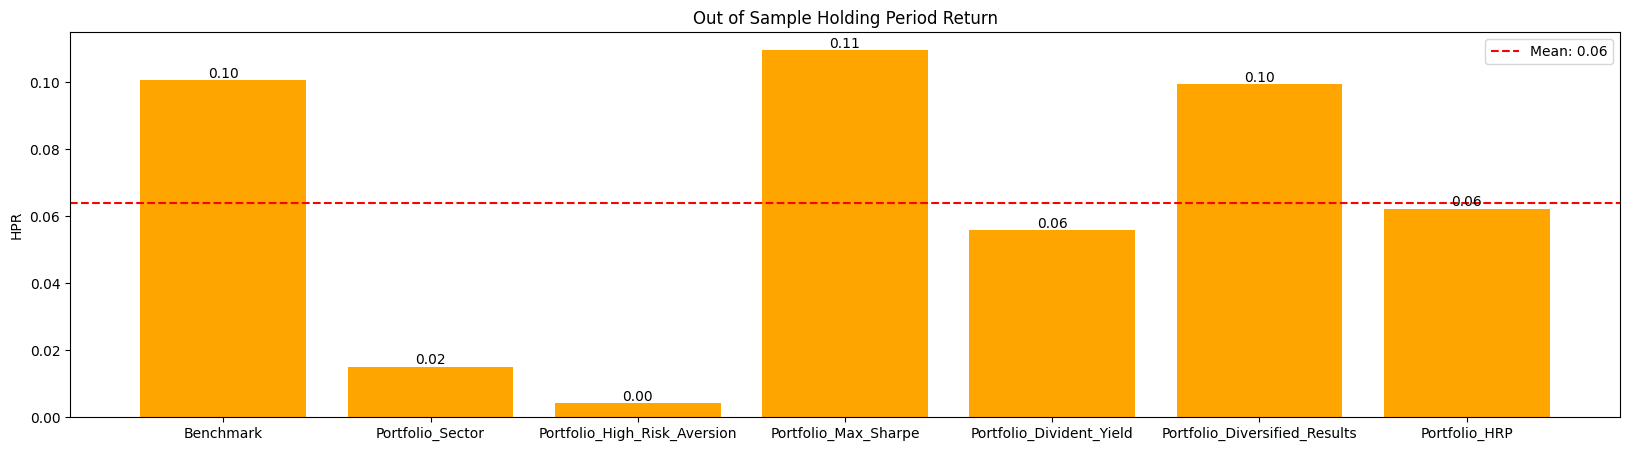

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Holding Period Return"], color='orange')
plt.title("Out of Sample Holding Period Return")
plt.ylabel("HPR")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Holding Period Return"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval+0.002, f"{yval:.2f}", ha='center', va='center', fontsize=10)

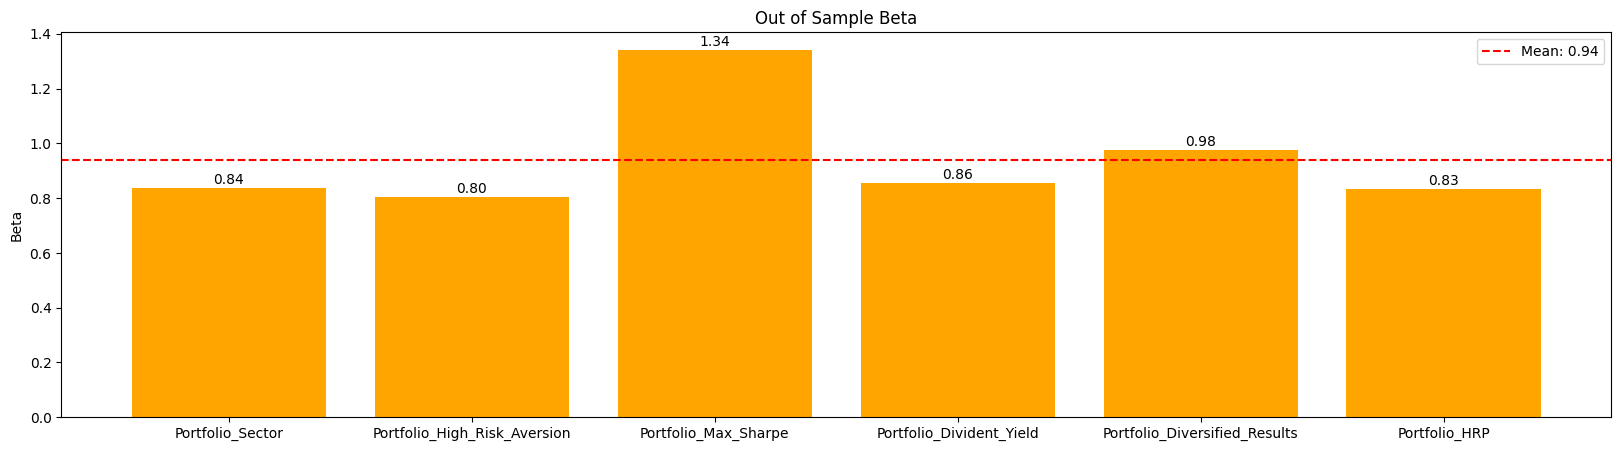

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Beta"], color='orange')
plt.title("Out of Sample Beta")
plt.ylabel("Beta")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Beta"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, f"{yval:.2f}", ha='center', va='center', fontsize=10)

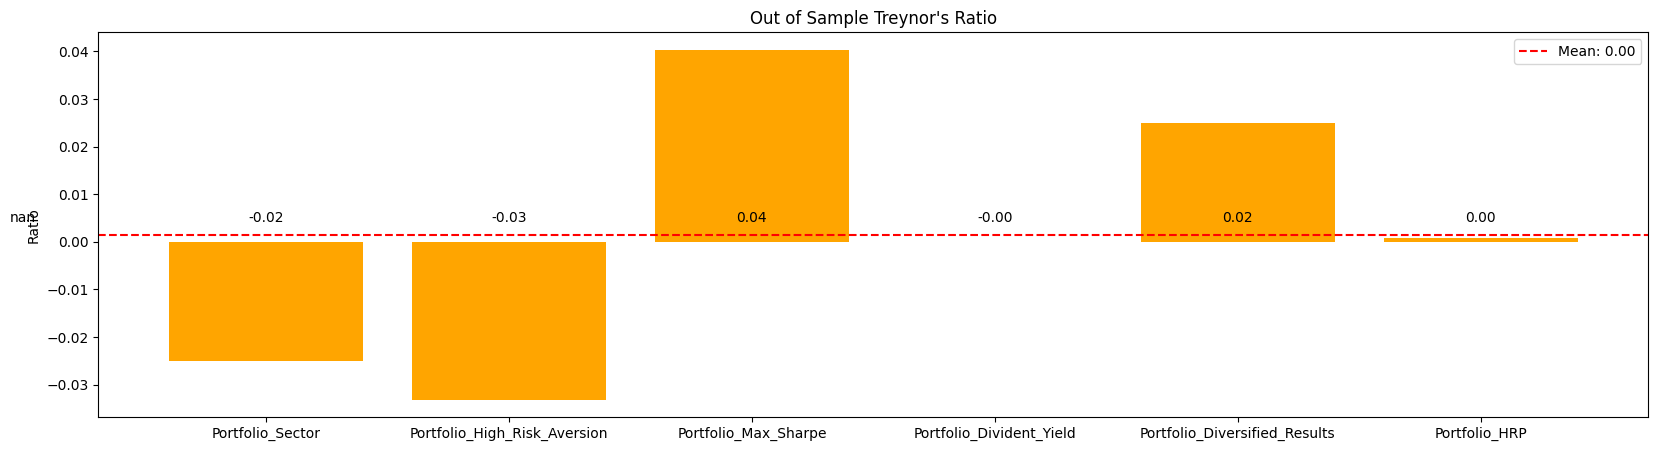

In [ ]:
plt.figure(figsize=(20, 5))
bars = plt.bar(oos_results_plot.index, oos_metrics["Out of Sample Portfolio Treynor's Ratio"], color='orange')
plt.title("Out of Sample Treynor's Ratio")
plt.ylabel("Ratio")
mean_value = np.mean(oos_metrics["Out of Sample Portfolio Treynor's Ratio"])
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.legend([f"Mean: {mean_value:.2f}"], loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 0.005, f"{yval:.2f}", ha='center', va='center', fontsize=10)

##### Evaluation (Model Description)

**Model 1**: Risk Aversion's portfolio is focused on reducing risk, by setting the risk_aversion value to 20, indicating a high degree of risk aversion, leading to a more diverse portfolio with a focus on reducing the risk. It is maximized using the quadratic utility function.

**Model 2**: We chose to experiment with maximizing the Sharpe Ratio. Sharpe ratio is an important metric that allows us to maximize our risk to reward ratio. At the same time, we also wish to lower our risk through some form of diversification. Hence, we set the max holdings of each stock <= 0.60. Therefore, our portfolio would be more resilient against single stock changes.

**Model 3**: We chose to experiment with prioritizing high dividend stocks. Dividend Investing is a valid strategy for conservative investors. Moreover, stocks included in the DJIA are considered generally stable with a high market cap. Hence, pursuing a greater weightage in higher dividend stocks may be an option.

For this, we grouped the stocks into 3 categories, based on their historic dividend yields. "High" indicates that they have a yield > 2%, "Medium" indicates that they have a yield between 1% to 2%, and "Low" indicates that they have a yield below 1%. We set a limit, indicating that the portfolio should have 0.5 < High < 0.7, 0.3 < Medium < 0.5, 0.1 < Low < 0.3 so that the portfolio will not be fully invested in High Dividend Stocks. This is because we wish to make a portfolio that has a priority and importance to Dividend yields, but not an entirely dividend fund.

Following that, we utilized L2 Regularization to ensure that all stocks are considered. The aim is to reduce risk by diversification, which hopefully makes this portfolio more robust to single stock changes. Lastly, we also used a more neutral risk aversion metric to optimize for a balanced portfolio.

**Model 4**: Diversified Portfolio aims to diversify the portfolio by minimizing the portfolio variance. For every stock, we ensure that the portfolio variance is maintained less than 0.05. We also limit that every stock must have weight 0.01 < x < 0.2. Ideally, this should ensure that our portfolio is diverse across market movements. This should make the portfolio more resistant to singular stock fluctuations as the other stocks in the portfolio do not move in the same pattern. We also used a more neutral risk_aversion to metric for this portfolio.

**Model 5**: Sector Constraints's portfolio considers the industries or sectors of the individual stocks within the portfolio, with sectors such as Information Technology (IT), Food & Beverage. The portfolio adds constraints to the sectors, and in our specific case, ensures that the IT takes up 10% - 70% of the portfolio, finance between 10% and 20% of the portfolio. With the sector constraints added, the portfolio is then maximized using the quadratic utility function and on a risk aversion of 20, similar to that of model 1's portfolio.

**Model 6**: Hierarchical Risk Parity diversifies the portfolio by allocating weights to assets based on their risk contributions within a hierarchical structure. The assets are grouped into clusters based on their risk characteristics and correlations. Within each cluster, a risk parity allocation is performed to ensure that each asset contributes equally to the cluster’s risk. Then the same thing is done at the cluster level and each cluster receives a weight based on its overall risk contribution to the entire portfolio.


##### Evaluation (Results)

**Metric 1: Portfolio Return**

Portfolio Return measures the percentage Log return of the portfolio. For the Out Sample metrics, the Max Sharpe portfolio has the best returns at 10.38%, which is likely due to it maximizing the risk-to-reward ratio and choosing assets that are undervalued and have potential for growth while diversifying such that it can capture the pockets of strong performance in certain sectors and mitigate losses in others.

**Metric 2: Annualized SD**

Annualized SD measures the standard deviation of the portfolio across the period. For the Out Sample metrics, the HRP portfolio has the lowest SD at 0.21, which is expected as HRP has a robust diversification, which could result in lower volatility as there are fewer correlations between the assets, so it avoids overweighing assets that could be similar in risk profiles.

**Metric 3: Annualised Sharpe**

The annualized Sharpe is the Sharpe ratio annualized. The Sharpe ratio compares the return of an investment with its risk. A higher Sharpe ratio indicates a higher return associated with a lower risk, whereas a lower Sharpe ratio indicates a lower return associated with a higher level of risk.

The In Sample metrics results show that Model 2, the model maximizing the Sharpe ratio, yields the highest Sharpe ratio of 2.269071, with Model 6 Hierarchical Risk Parity yielding the lowest Sharpe ratio of 0.855949. Noticeably, the benchmark fares poorly in this metric, yielding the second-lowest Sharpe ratio of 0.542294. All other portfolios by the other models yield a Sharpe ratio between 1.0 and 2.0

The Out of Sample metrics illustrate a stark difference in the magnitude of the Annualised Sharpe ratio, with all values between 0.01 to 0.50. The portfolio yielding the highest Sharpe ratio is now the benchmark itself, with a value of 0.426434. The Sharpe ratio of the max Sharpe portfolio has fallen to 0.264988. The lowest Sharpe ratio of 0.018967 belongs to the portfolio with high-risk aversion under model 1.

The large differences and changes in the Annualised Sharpe ratio in sample and out of sample could be attributed to the fact that they are external factors affecting the market such as market cycles, and macroeconomic factors, that were unaccounted for. In this specific case, it was likely due to the rise of the COVID-19 pandemic that had led to an economic downturn, causing lower expected returns and higher volatility and risk, leading to a generic fall in the Sharpe ratio.

**Metric 4: Sortino Ratio**

The Sortino Ratio differentiates harmful volatility from total overall volatility by using the asset’s standard deviation of negative portfolio returns-downside deviation- instead of the total standard deviation of portfolio returns. The Sortino ratio takes an asset or portfolio’s return subtracts the risk-free rate, and then divides that amount by the asset’s downside deviation.

The out-sample metrics results show that the Portfolio_Diversified_Results and the Porfolio_HRP have higher-than-average ratios at 0.36 and 0.29 respectively, as these diversified portfolios consist of assets that are not correlated together. Moreover, diversification spreads investments across various assets and sectors. Hence, the likelihood of all assets in the portfolio experiencing a simultaneous drawdown will be reduced and will perform better relative to downside risks. The Portfolio_High_Risk_Aversion has the lowest Sortino Ratio at 0.09. A reason for this is that the portfolio might not be achieving sufficiently high returns above the minimum acceptable return, as shown in the Out of Sample Portfolio Returns graph, to compensate for the downside risk it experiences.


**Metric 5: 99% Historic VaR**

Historical VaR involves analyzing the historical returns of the portfolio over a specified time period to determine the likelihood of experiencing a certain level of loss in the future. It is based on the assumption that past market behavior is a good indicator of future market behavior. With a 99% Historical VaR, we are finding the maximum potential loss the portfolio may suffer 99% of the time.

The In Sample metrics show the portfolio based on model 2 that maximizes the Sharpe ratio to have the highest magnitude of VaR at 0.056565, and the portfolio based on model 5 with sector constraints to have the lowest VaR magnitude of 0.029652. It is also worth noting that the second-lowest 99% VaR was 0.029784 from the portfolio based on model 1 with high-risk aversion. All other values fall between 0.03 and 0.05.

Out of Sample metrics, the portfolio based on model 2 that maximizes the Sharpe ratio still has the highest magnitude of VaR at 0.048706, whereas the portfolio based on model 6 building upon Hierarchical Risk Parity is the lowest with a magnitude of 0.024643. The other values lie between the range of 0.025 and 0.03.

The slight drop in the VaR magnitudes could be attributed to the difference in the time periods used to calculate the in-sample and out-of-sample. The in-sample period likely experienced higher volatility and thus more days with lower returns, causing the 1% percentile to be of a higher magnitude.


**Metric 6: Calmar Ratio**

The Calmar ratio is a risk-adjusted performance measure that compares the annualized return of an investment portfolio with its maximum drawdown over a given period. The higher the Calmar ratio, the better the portfolio’s performance relative to the risk it has taken.

For the Out-of-sample metrics, every model has a Calmer ratio that is lower than the benchmark model (Calmer ratio = 0.32), that is, all the models have lower risk-adjusted returns compared to the benchmark model. Of the models, the portfolio with high-risk aversion, that is, model 1, has the lowest risk-adjusted returns since it has the lowest Calmer ratio of 0.07. The diversified portfolio model, that is, model 4, has a Calmer ratio of 0.31, and hence is the model with the closest risk-adjusted returns as the benchmark model.

**Metric 7: HPR**

Holding period return is the total return received from holding an asset or portfolio of assets over a period of time, known as the holding period. It is generally expressed as a percentage and is particularly useful for comparing returns on investments purchased at different periods in time.

For the Out Sample metrics, the Max Sharpe Model and Diversified Results perform best, with a HPR of 0.109350 and 0.099340. Risk Aversion Model performed the worst, at 0.004097. This is in line with our expectations as maximizing the Risk to Reward ratio will likely result in a more volatile HPR. In this case, the market performed well and the Max Sharpe Model managed to slightly outperform the benchmark. For risk aversion, the portfolio may be focused on more stable stocks, resulting in a marginal return rate.

**Metric 8: Beta**

​​Beta is a measure of the systematic risk of a portfolio relative to the market benchmark and reflects the sensitivity of an individual portfolio to market risk. When the beta is greater than 1, the investment portfolio is more sensitive to volatility risk than the market benchmark. When beta is less than 1, the investment portfolio is less sensitive to volatility risk than the market benchmark. When it is less than 0, there is an inverse relationship between portfolio sensitivity and market benchmark.

The out-of-sample metrics results show that the Diversified Model, which has a beta value of 0.98, behaves the most similar to the benchmark portfolio, although it is slightly less volatile than the overall market. This model has a volatility risk closest to the market portfolio.

**Metric 9: Treynor’s Ratio**

The Treynor’s ratio is a reward-to-volatility ratio performance metric for determining how much excess return, as compared to risk-free return, was generated for each unit of risk taken on by a portfolio

The Max Sharpe Model has the highest Treynor’s ratio at 0.04. As Treynor’s ratio specifically focuses on systematic risk, the current model could have produced a portfolio that has good overall risk management and potentially some outperformance from capturing undervalued assets. It could also be possible that the assets selected inherently have low unsystematic risk, leading to a higher Treynor’s ratio.
